## import packages

In [29]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import pandas as pd # for creation of data frames
import numpy as np #
import pyls # PLS: behavioral and mean-centered
import seaborn as sns
import nibabel as nib # for loading niftis etc. as arrays
import matplotlib.pyplot as plt # for plotting data
#the output of plotting commands is displayed inline, directly below the code cell that produced it
%matplotlib inline 
import os,glob
from nilearn import plotting, input_data, image #for plotting & working with niftis
from scipy import stats 

import pathlib

###################### update path!! #####################################
base_path = '/root_dir/' ####
##########################################################################

#import qBOLD functions
#import sys
#sys.path.append(os.path.join(base_path + 'scripts/'))
#import mqBOLD_functions as qB


### define FSL directories ######################################################
os.environ["FSLDIR"]='/usr/share/fsl/5.0'
os.environ["FSLOUTPUTTYPE"]='NIFTI_GZ'
os.environ["FSLTCLSH"]='/usr/bin/tclsh'
os.environ["FSLWISH"]='/usr/bin/wish'
os.environ["FSLMULTIFILEQUIT"]="True"
os.environ["LD_LIBRARY_PATH"]='/usr/share/fsl/5.0:/usr/lib/fsl/5.0'
#################################################################################

## define variables (please check!)

In [30]:
data_dir = base_path + 'data/'
derivatives_dir = data_dir + 'derivatives'
raw_dir = data_dir + 'rawdata'
results_dir = base_path + 'results'
MNI_2mm_brain = derivatives_dir + '/MNI152_T1_2mm_brain.nii.gz'

sns.set_style("whitegrid")

coords=(-15, 0, 15, 30, 45, 60, 75, 90)

## run qBOLD toolbox
%run qBOLD_fun.ipynb

In [37]:
## Please which CMRO2 version to use ##
###################################################

#CMRO2_mode = 'orig' ## orig = CMRO2 maps NOT corrected for CBV changes, only CMRO2 maps of subj > 55 in CALC condition are corrected for CBV increases
CMRO2_mode = 'corrected' ## CMRO2 CALC maps corrected for CBV changes (but MEM maps are not corrected)

## Please specify task & baseline ##
####################################

baseline='control'
task='calc'
conds = [baseline, task]
contrast=task+baseline

## Please specify subject list##
################################

if baseline == 'control' and task == 'calc':
    #N=40
    sids = [19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68]
else: #N=30, without p053
    sids = [19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55]

#N=30
sids_30 = [19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55]

##########################################################
## please select which group task mask to apply!! ##
##########################################################

#masks = ['Yeo', 'PLS BOLD', 'PLS CBF', 'GLM BOLD']
#masks = ['PLS CBF', 'PLS CMRO2', 'PLS OEF']
mask = [ 'PLS BOLD'] ## this is the PLS BOLD group mask
#masks = [ 'PLS CBF']
#masks = ['GLM_BOLD']


### other variables ##############
##################################

N_subj = str(len(sids))
GM_thresh = 0.5
BSR_thr=2

## Gray-matter mask, excluding areas with low signal-to-noise ratio according to fMRI data

YEO_SNR_mask = os.path.join( derivatives_dir, 'task-all_space-MNI152_res-2_SNR_YEO_group_mask.nii.gz')
mask_img = nib.load(YEO_SNR_mask)
masker_GM = input_data.NiftiMasker(mask_img=YEO_SNR_mask) ## exclude areas with too less SNR (based on the localizer data)
YEO_SNR_mask_arr = np.array(mask_img.dataobj)

### Blue-red color palette

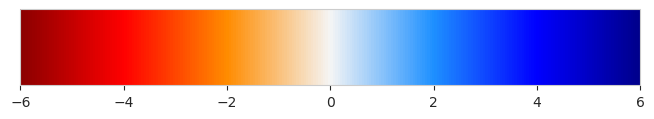

In [38]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

colors = ["darkblue", "blue", "dodgerblue",  "whitesmoke","darkorange", "red", "darkred"]
BlueRed = LinearSegmentedColormap.from_list("mycmap", colors)

fig, ax = plt.subplots(figsize=(3,0.5))
fig.subplots_adjust(bottom=0.5)

bounds = [-6, -4, -2, 0, 2, 4, 6]
norm = mpl.colors.Normalize(vmin=-6, vmax=6)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=BlueRed), 
             cax=ax, ticks=bounds, orientation='horizontal')

## inverted colormap: BlueRed_r
colors = [ "darkred","red", "darkorange", "whitesmoke", "dodgerblue", "blue","darkblue"]
BlueRed_r = LinearSegmentedColormap.from_list("mycmap", colors)

fig, ax = plt.subplots(figsize=(8, 2))
fig.subplots_adjust(bottom=0.5)

bounds = [-6, -4, -2, 0, 2, 4, 6]
norm = mpl.colors.Normalize(vmin=-6, vmax=6)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=BlueRed_r), 
             cax=ax, ticks=bounds, orientation='horizontal')

## Fig. 4A, baseline hemodynamics

In [41]:
## difference in medians
def statistic(x_true, x_false):
        return np.median(x_true, axis=0) - np.median(x_false, axis=0)
def statistic_GM(x_GM, x_false):
        return np.median(x_GM, axis=0) - np.median(x_false, axis=0)

In [39]:
parameters = [ 'oef','cmro2', 'cbf', 'cbv']
#parameters = [ 'rOEF', 'CMRO2']

##choose if negative (DMN) or positive BOLD areas
colormap = (["plum", "darkviolet"])

##only in baseline cond
baseline_cond = 'control'
BOLD_ROI = 'all'

## create array of masks with all concordant and all discordant voxels ##
#################################################################
masks_concord=[]
masks_discord=[]
contrasts = ['calccontrol', 'memcontrol']
## these masks are output from script E, Fig. 3
for contrast in contrasts:

    ## divide into: real deactivation and dissociation areas!
    PLS_true_deact = os.path.join(results_dir, 'negBOLD_negCMRO2_' + contrast + '.nii.gz') #negBOLD_negCMRO2_memcontrol_CMRO2deact
    #plotting.plot_img(PLS_true_deact, cmap=colormap,  bg_img=MNI_brain, threshold=0, display_mode='z')

    PLS_dissociation = os.path.join(results_dir, 'negBOLD_posCMRO2_' + contrast + '.nii.gz')
    #plotting.plot_img(PLS_dissociation, cmap=colormap,  bg_img=MNI_brain, threshold=0, display_mode='z')
    
    masks_concord.append(PLS_true_deact)
    masks_discord.append(PLS_dissociation)
    
    ## divide into: real deactivation and dissociation areas!
    PLS_true_act =  os.path.join(results_dir, 'posBOLD_posCMRO2_' + contrast + '.nii.gz')

    #plotting.plot_img(PLS_true_act, cmap=colormap,  bg_img=MNI_brain, threshold=0, display_mode='z')

    PLS_dissociation = os.path.join(results_dir,  'posBOLD_negCMRO2_' + contrast + '.nii.gz')
    #plotting.plot_img(PLS_dissociation, cmap=colormap,  bg_img=MNI_brain, threshold=0, display_mode='z')

    masks_concord.append(PLS_true_act)
    masks_discord.append(PLS_dissociation)
    
    
## create mask that only has GM voxels, but not all other PLS voxels
GM_YEO = YEO_SNR_mask
PLS_calccontrol = results_dir + '/N40_BSR_meanPLS_func_clusterBSRcalccontrol.nii.gz'
PLS_calccontrol_bin = results_dir + '/N40_BSR_meanPLS_func_clusterBSRcalccontrol_bin.nii.gz'
! fslmaths {PLS_calccontrol} -abs -bin {PLS_calccontrol_bin}
PLS_memcontrol = results_dir + '/N30_BSR_meanPLS_func_clusterBSRmemcontrol.nii.gz'
PLS_memcontrol_bin = results_dir + '/N30_BSR_meanPLS_func_clusterBSRmemcontrol_bin.nii.gz'
GM_mask_without_PLS = results_dir + '/GM_vox_without_calccontrol_memcontrol_vox.nii.gz'
! fslmaths {PLS_memcontrol} -abs -bin {PLS_memcontrol_bin}
! fslmaths {GM_YEO} -add {PLS_calccontrol_bin} -add {PLS_memcontrol_bin} -uthr 1 {GM_mask_without_PLS}
plotting.plot_img(GM_mask_without_PLS, cmap='jet',  bg_img=MNI_2mm_brain, threshold=0, display_mode='z')

masker_GM = input_data.NiftiMasker(mask_img = YEO_SNR_mask)
masker_GM_woPLS = input_data.NiftiMasker(mask_img = GM_mask_without_PLS)
GM_mask_without_PLS_arr = np.array(nib.load(GM_mask_without_PLS).dataobj)

for par in parameters: 
    vox_true= []
    vox_diss= []
    
    ##################################
    ## all concordant voxels ##
    #################################
    
    for m, mask in enumerate(masks_concord): ## masks: 4 masks: all condordant, two contrasts, either both pos or both neg
        masker = input_data.NiftiMasker(mask_img = mask) 
        mask_arr = np.array(nib.load(mask).dataobj)
        mask_arr_GM = np.array(nib.load(YEO_SNR_mask).dataobj)
        mask_arr_GM_woPLS = np.array(nib.load(GM_mask_without_PLS).dataobj)
        par_median_vox = np.zeros((len(np.argwhere(mask_arr)), len(sids)))
        par_median_vox_GM  = np.zeros((len(np.argwhere(mask_arr_GM)), len(sids)))
        par_median_vox_GM_woPLS  = np.zeros((len(np.argwhere(mask_arr_GM_woPLS)), len(sids)))
        for i, ID in enumerate(sids): #loop over subjects
            sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
            print(sub)

            sub_dir = os.path.join(data_dir, sub)

            dir_anat = os.path.join(sub_dir, 'anat')
            dir_func = os.path.join(sub_dir, 'func')
            dir_perf = os.path.join(sub_dir, 'perf')

            dir_anat_deriv = os.path.join(derivatives_dir, sub, 'anat')
            dir_func_deriv = os.path.join(derivatives_dir, sub, 'func')
            dir_perf_deriv = os.path.join(derivatives_dir, sub, 'perf')
            dir_qmri_deriv = os.path.join(derivatives_dir, sub, 'qmri')

            ## 
            if par !='cmro2':
                par_map = os.path.join(dir_qmri_deriv, sub + '_task-' + baseline_cond + '_space-MNI152_'+par+'.nii.gz')
            if par =='cmro2':
                par_map = os.path.join(dir_qmri_deriv, sub + '_task-' + baseline_cond + '_space-MNI152_desc-orig_'+par+'.nii.gz')           
            
                                  
            # mask with voxels that are within mask
            par_arr = np.squeeze(masker.fit_transform(par_map)) 
            if par == 'cbf': ##25% too low
                par_arr = par_arr/0.75
            
            if m == 0: ## get GM values (do not mask with mask, but with whole-brain GM mask)
                if par != 'cbf':
                    par_arr_GM = np.squeeze(masker_GM.fit_transform(par_map))   
                    par_arr_GM_woPLS = np.squeeze(masker_GM_woPLS.fit_transform(par_map))   
                if par == 'cbf':
                    par_arr_GM = np.squeeze(masker_GM.fit_transform(par_map))/0.75   
                    par_arr_GM_woPLS = np.squeeze(masker_GM_woPLS.fit_transform(par_map))/0.75   
                
            ## all voxels within mask
            par_median_vox[:, i] = par_arr
                
            ## all voxels within GM
            if m == 0:
                par_median_vox_GM[:, i] = par_arr_GM
                par_median_vox_GM_woPLS[:, i] = par_arr_GM_woPLS

           
        ##median across subjects per voxel 
        par_median_voxel = np.nanmedian(par_median_vox, axis = 1)
        if m == 0:
            par_median_GM =  np.nanmedian(par_median_vox_GM, axis = 1)
            par_median_GM_woPLS =  np.nanmedian(par_median_vox_GM_woPLS, axis = 1)
            
        ## append all voxels 
        vox_true.append(par_median_voxel)
        vox_GM = par_median_GM
        vox_GM_woPLS = par_median_GM_woPLS
        
        if par == 'cmro2':
            vox_conc_CMRO2 = np.array([item for sublist in vox_true for item in sublist])
            vox_GM_CMRO2 = vox_GM
            vox_GM_woPLS_CMRO2 =  vox_GM_woPLS
        if par == 'oef':
            vox_conc_OEF = np.array([item for sublist in vox_true for item in sublist])
            vox_GM_OEF =  vox_GM
            vox_GM_woPLS_OEF= vox_GM_woPLS
        if par == 'cbf':
            vox_conc_CBF = np.array([item for sublist in vox_true for item in sublist])
            vox_GM_CBF =  vox_GM
            vox_GM_woPLS_CBF = vox_GM_woPLS
        if par == 'cbv':
            vox_conc_CBV = np.array([item for sublist in vox_true for item in sublist])
            vox_GM_CBV =  vox_GM
            vox_GM_woPLS_CBV = vox_GM_woPLS
            
    ##################################
    ## all discordant voxels ##
    #################################
    
    for m, mask in enumerate(masks_discord):
        masker = input_data.NiftiMasker(mask_img = mask) 
        mask_arr = np.array(nib.load(mask).dataobj)
        par_median_vox = np.zeros((len(np.argwhere(mask_arr)), len(sids)))
        for i, ID in enumerate(sids): #loop over subjects
            sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
            print(sub)

            sub_dir = os.path.join(data_dir, sub)

            dir_anat = os.path.join(sub_dir, 'anat')
            dir_func = os.path.join(sub_dir, 'func')
            dir_perf = os.path.join(sub_dir, 'perf')

            dir_anat_deriv = os.path.join(derivatives_dir, sub, 'anat')
            dir_func_deriv = os.path.join(derivatives_dir, sub, 'func')
            dir_perf_deriv = os.path.join(derivatives_dir, sub, 'perf')
            dir_qmri_deriv = os.path.join(derivatives_dir, sub, 'qmri')

            ## 
            if par !='cmro2':
                par_map = os.path.join(dir_qmri_deriv, sub + '_task-' + baseline_cond + '_space-MNI152_'+par+'.nii.gz')
            if par =='cmro2':
                par_map = os.path.join(dir_qmri_deriv, sub + '_task-' + baseline_cond + '_space-MNI152_desc-orig_'+par+'.nii.gz')           
            
            
            # mask with voxels that are within mask
            par_arr = np.squeeze(masker.fit_transform(par_map))   
            if par == 'cbf':
                par_arr = par_arr/0.75
                
            ## all voxels within mask
            par_median_vox[:, i] = par_arr

           
        ##median across subjects per voxel 
        par_median_voxel = np.nanmedian(par_median_vox, axis = 1)
            
        ## append all voxels 
        vox_diss.append(par_median_voxel)
        
        if par == 'cmro2':
            vox_disc_CMRO2 = np.array([item for sublist in vox_diss for item in sublist])
        if par == 'oef':
            vox_disc_OEF = np.array([item for sublist in vox_diss for item in sublist])
        if par == 'cbf':
            vox_disc_CBF = np.array([item for sublist in vox_diss for item in sublist])      
        if par == 'cbv':
            vox_disc_CBV = np.array([item for sublist in vox_diss for item in sublist])    
            
##create dataframes

## all GM voxels
df_GM_woPLS = pd.DataFrame()
df_GM_woPLS['cmro2'] = vox_GM_woPLS_CMRO2
df_GM_woPLS['oef'] = vox_GM_woPLS_OEF
df_GM_woPLS['cbf'] = vox_GM_woPLS_CBF
df_GM_woPLS['cbv'] = vox_GM_woPLS_CBV

## all concordant
df_conc_vox = pd.DataFrame()
df_conc_vox['cmro2'] = vox_conc_CMRO2
df_conc_vox['oef'] = vox_conc_OEF
df_conc_vox['cbf'] = vox_conc_CBF
df_conc_vox['cbv'] = vox_conc_CBV

## all discordant
df_disc_vox = pd.DataFrame()
df_disc_vox['cmro2'] = vox_disc_CMRO2
df_disc_vox['oef'] = vox_disc_OEF
df_disc_vox['cbf'] = vox_disc_CBF
df_disc_vox['cbv'] = vox_disc_CBV

sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
sub-p058
sub-p059
sub-p060
sub-p061
sub-p063
sub-p064
sub-p065
sub-p066
sub-p067
sub-p068
sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
sub-p058
sub-p059
sub-p060
sub-p061
sub-p063
sub-p064
sub-p065
sub-p066
sub-p067
sub-p068
sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
sub-p058
s

permutation statistics true vs. false regions: 0.0004
permutation statistics false vs GM value: 0.0004


TypeError: regplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 3 keyword-only arguments) were given

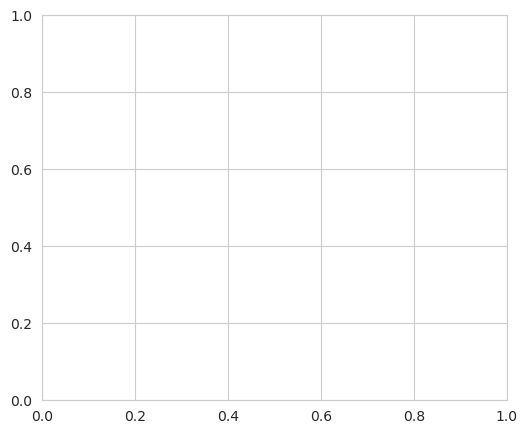

In [42]:
from scipy import stats 

fontsize=25

### kick out values that are too high
df_GM_woPLS[df_GM_woPLS['cmro2'] > 350] = np.nan
df_GM_woPLS[df_GM_woPLS['oef'] > 1] = np.nan
df_disc_vox[df_disc_vox['cmro2'] > 350] = np.nan
df_disc_vox[df_disc_vox['oef'] > 1] = np.nan
df_conc_vox[df_conc_vox['cmro2'] > 350] = np.nan
df_conc_vox[df_conc_vox['oef'] > 1] = np.nan


    ############################################
    ## plot ####################################
    ############################################

colormap = (["plum", "darkviolet", "gray"])

############################################
## OEF baseline
############################################
    

##permutation test, because data are smoothed/non-independent
res = stats.permutation_test((df_conc_vox['oef'] , df_disc_vox['oef']), statistic, permutation_type='independent', n_resamples=5000, alternative='two-sided')
p_true_false = res.pvalue
print('permutation statistics true vs. false regions: ' + str(round(p_true_false, 6)))
res_GM = stats.permutation_test((df_GM_woPLS['oef'], df_disc_vox['oef']), statistic_GM, permutation_type='independent', n_resamples=5000, alternative='two-sided')
p_false_GM = res_GM.pvalue
print('permutation statistics false vs GM value: ' + str(round(p_false_GM, 6))) 


fig, (ax1) = plt.subplots(1, figsize=(2.5, 4.5))
sns.violinplot(data=[df_conc_vox['oef'], df_disc_vox['oef']],inner='box',
                    ax=ax1, palette=colormap)
ax1.set_xticklabels(['conc.', 'disc.'])
ax1.hlines(np.nanmedian(df_GM_woPLS['oef'] ),-0.5, 1.5, color='gray', linestyles='dashed')
ax1.hlines(np.nanmedian(df_conc_vox['oef'] ),-0.5, 1.5, color=colormap[0], linestyles='dashed')        
ax1.hlines(np.nanmedian(df_disc_vox['oef']),-0.5, 1.5, color=colormap[1], linestyles='dashed')
if p_true_false < 0.001:
            ax1.text(0.3, 1, '**', color='grey', fontsize=fontsize)
ax1.set_ylabel('OEF [ratio]', fontsize=fontsize)
ax1.set_ylim(0, 1.1)
ax1.text(1.5, 0.45, round(np.nanmedian(df_GM_woPLS['oef']), 2), color=colormap[2], fontsize=fontsize)
ax1.text(1.5, 0.38, round(np.nanmedian(df_conc_vox['oef']), 2), color=colormap[0], fontsize=fontsize)
ax1.text(1.5, 0.3, round(np.nanmedian(df_disc_vox['oef']), 2), color=colormap[1], fontsize=fontsize)
#ax1.set_title('CTRL', fontsize=fontsize)
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
            label.set_fontsize(fontsize)
        #ax.set_title('coupling CBF/BOLD, CMRO2/BOLD')

for pos in ['right', 'top']:
            ax1.spines[pos].set_visible(False)

fig.savefig(results_dir + '/N' + N_subj + '_BOLD' + BOLD_ROI + '_' + par + '_disc_concord_allCTRLcontrasts.png', dpi=300, bbox_inches='tight')
fig.show()
        
        
### CMRO2 base vs OEFbase
############################################
fig, ax = plt.subplots(1, figsize=(6, 5))

##all other GM voxels
sns.regplot(df_GM_woPLS['cmro2'].dropna(), df_GM_woPLS['oef'].dropna(), ax=ax, color='gray', scatter_kws={'s':2})
(r, p) = stats.pearsonr(df_GM_woPLS['cmro2'].dropna(), df_GM_woPLS['oef'].dropna())
if p < 0.001:
    ax.text(200,0.3, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='gray')    

##discordant
sns.regplot(df_disc_vox['cmro2'].dropna(), df_disc_vox['oef'].dropna(), ax=ax, color='darkviolet', scatter_kws={'s':3})
(r, p) = stats.pearsonr(df_disc_vox['cmro2'].dropna(), df_disc_vox['oef'].dropna())  
if p < 0.001:
    ax.text(200,0.2, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='darkviolet')  
    
##concordant
sns.regplot(df_conc_vox['cmro2'].dropna(), df_conc_vox['oef'].dropna(), ax=ax, color='plum', scatter_kws={'s':3})
(r, p) = stats.pearsonr(df_conc_vox['cmro2'].dropna(), df_conc_vox['oef'].dropna())
if p < 0.001:
    ax.text(200,0.1, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='plum') 


ax.set_xlim(0, 350)
ax.set_ylim(0, 1)

ax.set_xlabel('CMRO2 [μmol/100g/min]', fontsize=fontsize)
ax.set_ylabel('OEF [ratio]', fontsize=fontsize)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)
        #ax.set_title('coupling CBF/BOLD, CMRO2/BOLD')

for pos in ['right', 'top']:
            ax.spines[pos].set_visible(False)

fig.savefig(results_dir + '/N' + N_subj + '_BOLD' + BOLD_ROI + '_disc_concord_base_OEF_CMRO2_allCTRLcontrasts.png', dpi=300, bbox_inches='tight')
fig.show()

### CMRO2 base vs CBFbase
############################################
fig, ax = plt.subplots(1, figsize=(6, 5))

##all other GM voxels
sns.regplot(df_GM_woPLS['cmro2'].dropna(), df_GM_woPLS['cbf'].dropna(), ax=ax, color='gray', scatter_kws={'s':2})
(r, p) = stats.pearsonr(df_GM_woPLS['cmro2'].dropna(), df_GM_woPLS['cbf'].dropna())
if p < 0.001:
    ax.text(200,20, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='gray')    

##discordant
sns.regplot(df_disc_vox['cmro2'].dropna(), df_disc_vox['cbf'].dropna(), ax=ax, color='darkviolet', scatter_kws={'s':3})
(r, p) = stats.pearsonr(df_disc_vox['cmro2'].dropna(), df_disc_vox['cbf'].dropna())
if p < 0.001:
    ax.text(200,13, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='darkviolet')    

##concordant
sns.regplot(df_conc_vox['cmro2'].dropna(), df_conc_vox['cbf'].dropna(), ax=ax, color='plum', scatter_kws={'s':3})
(r, p) = stats.pearsonr(df_conc_vox['cmro2'].dropna(), df_conc_vox['cbf'].dropna())
if p < 0.001:
    ax.text(200,6, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='plum') 

ax.set_xlim(0, 350)
ax.set_ylim(0, 70)

ax.set_xlabel('CMRO2 [μmol/100g/min]', fontsize=fontsize)
ax.set_ylabel('CBF [ml/100g/min]', fontsize=fontsize)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)
        #ax.set_title('coupling CBF/BOLD, CMRO2/BOLD')

for pos in ['right', 'top']:
            ax.spines[pos].set_visible(False)

fig.savefig(results_dir + '/N' + N_subj + '_BOLD' + BOLD_ROI + '_disc_concord_base_CBF_CMRO2_allCTRLcontrasts.png', dpi=300, bbox_inches='tight')
fig.show()


### CMRO2 base vs CBVbase
############################################
fig, ax = plt.subplots(1, figsize=(6, 5))

##all other GM voxels
sns.regplot(df_GM_woPLS['cmro2'].dropna(), df_GM_woPLS['cbv'].dropna(), ax=ax, color='gray', scatter_kws={'s':2})
(r, p) = stats.pearsonr(df_GM_woPLS['cmro2'].dropna(), df_GM_woPLS['cbv'].dropna())
if p < 0.001:
    ax.text(200,1.5, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='gray')    

##discordant
sns.regplot(df_disc_vox['cmro2'].dropna(), df_disc_vox['cbv'].dropna(), ax=ax, color='darkviolet', scatter_kws={'s':3})
(r, p) = stats.pearsonr(df_disc_vox['cmro2'].dropna(), df_disc_vox['cbv'].dropna())
if p < 0.001:
    ax.text(200,0.8, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='darkviolet')    

##concordant
sns.regplot(df_conc_vox['cmro2'].dropna(), df_conc_vox['cbv'].dropna(), ax=ax, color='plum', scatter_kws={'s':3})
(r, p) = stats.pearsonr(df_conc_vox['cmro2'].dropna(), df_conc_vox['cbv'].dropna())
if p < 0.001:
    ax.text(200,0.1, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='plum') 

ax.set_xlim(0, 350)
ax.set_ylim(0, 9)

ax.set_xlabel('CMRO2 [μmol/100g/min]', fontsize=fontsize)
ax.set_ylabel('CBV [%]', fontsize=fontsize)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)
        #ax.set_title('coupling CBF/BOLD, CMRO2/BOLD')

for pos in ['right', 'top']:
            ax.spines[pos].set_visible(False)

fig.savefig(results_dir + '/N' + N_subj + '_BOLD' + BOLD_ROI + '_disc_concord_base_CBV_CMRO2_allCTRLcontrasts.png', dpi=300, bbox_inches='tight')
fig.show()

        
## pie-plot discordant/concordant voxels
fig, ax = plt.subplots(1, figsize=(7,7))
   
num_vox = [len(df_GM_woPLS), len(df_conc_vox), len(df_disc_vox)]
ax.pie(num_vox, labels=['','',''],autopct = '%0.0f%%', startangle = 79.5, explode = [0.03,0.03, 0.03],
        textprops = {'fontsize':25, 'color':'white'}, colors=['gray', 'plum', 'darkviolet'], wedgeprops = {'linewidth': 6, 'alpha':0.8}, center = (0.1,0.1))


ax.legend( bbox_to_anchor=(0.8, 0), labels = ['GM', 'concordant vox', 'discordant vox'], fontsize=14, shadow=True)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)
        #ax.set_title('coupling CBF/BOLD, CMRO2/BOLD')

for pos in ['right', 'top']:
            ax.spines[pos].set_visible(False)

fig.savefig(results_dir + '/N' + N_subj + '_BOLD' + BOLD_ROI + '_pieplot_allCTRLcontrasts.png', dpi=300, bbox_inches='tight')
fig.show()

## Multiple linear regression predicting CMRO2

### concordant voxels

In [47]:
import pingouin as pg

## concordant voxels

## center predictors beforehands: 
df_conc_vox_centered = pd.DataFrame()
df_conc_vox_centered['cmro2'] = df_conc_vox['cmro2'].dropna()
df_conc_vox_centered['oef'] = df_conc_vox['oef'].dropna() - np.nanmean(df_conc_vox['oef'].dropna())
df_conc_vox_centered['cbf'] = df_conc_vox['cbf'].dropna() - np.nanmean(df_conc_vox['cbf'].dropna())
df_conc_vox_centered['cbv'] = df_conc_vox['cbv'].dropna() - np.nanmean(df_conc_vox['cbv'].dropna())

x = df_conc_vox_centered[['oef', 'cbf', 'cbv']].dropna()
y = df_conc_vox_centered['cmro2'].dropna()

lm = pg.linear_regression(x,y, as_dataframe=False)

print('R2 = ' + str(lm['r2']))
print('beta values intercept, OEF, CBF, CBV = ' + str(lm['coef']))
print('p-values OEF, CBF, CBV = ' + str(lm['pval']))
print('df = ' + str(lm['df_resid']))

##Get the relative importance of predictors
lm = pg.linear_regression(x, y, remove_na=True, relimp=True)
lm[['names', 'relimp', 'relimp_perc']]

R2 = 0.9083707161849212
beta values intercept, OEF, CBF, CBV = [139.92001577 321.08705777   3.33774887   0.37534278]
p-values OEF, CBF, CBV = [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.58657183e-06]
df = 21809


names    relimp  relimp_perc
0  Intercept       NaN          NaN
1        oef  0.640104    70.467269
2        cbf  0.255241    28.098820
3        cbv  0.013025     1.433911

In [48]:
from statsmodels.formula.api import ols

## concordant voxels

model = ols('cmro2 ~ oef + cbf + cbv', data=df_conc_vox_centered).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  cmro2   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                 7.207e+04
Date:                Wed, 31 Jan 2024   Prob (F-statistic):               0.00
Time:                        18:10:08   Log-Likelihood:                -85774.
No. Observations:               21813   AIC:                         1.716e+05
Df Residuals:                   21809   BIC:                         1.716e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    139.9200      0.084   1673.717      0.0

### discordant voxels

In [49]:
## discordant voxels

import pingouin as pg

## center predictors beforehands: 
df_disc_vox_centered = pd.DataFrame()
df_disc_vox_centered['cmro2'] = df_disc_vox['cmro2'].dropna()
df_disc_vox_centered['oef'] = df_disc_vox['oef'].dropna() - np.nanmean(df_disc_vox['oef'].dropna())
df_disc_vox_centered['cbf'] = df_disc_vox['cbf'].dropna() - np.nanmean(df_disc_vox['cbf'].dropna())
df_disc_vox_centered['cbv'] = df_disc_vox['cbv'].dropna() - np.nanmean(df_disc_vox['cbv'].dropna())

x = df_disc_vox_centered[['oef', 'cbf', 'cbv']].dropna()
y = df_disc_vox_centered['cmro2'].dropna()

lm = pg.linear_regression(x,y, as_dataframe=False)

print('R2 = ' + str(lm['r2']))
print('beta values intercept, OEF, CBF, CBV = ' + str(lm['coef']))
print('p-values OEF, CBF, CBV = ' + str(lm['pval']))
print('df = ' + str(lm['df_resid']))

##Get the relative importance of predictors
lm = pg.linear_regression(x, y, remove_na=True, relimp=True)
lm[['names', 'relimp', 'relimp_perc']]

R2 = 0.9089429434134586
beta values intercept, OEF, CBF, CBV = [128.09995832 309.2379128    3.21388852   1.33398861]
p-values OEF, CBF, CBV = [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70873362e-44]
df = 14544


names    relimp  relimp_perc
0  Intercept       NaN          NaN
1        oef  0.615690    67.736911
2        cbf  0.269788    29.681547
3        cbv  0.023465     2.581542

In [50]:
## discordant voxels

model = ols('cmro2 ~ oef + cbf + cbv', data=df_disc_vox_centered).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  cmro2   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                 4.839e+04
Date:                Wed, 31 Jan 2024   Prob (F-statistic):               0.00
Time:                        18:14:25   Log-Likelihood:                -57105.
No. Observations:               14548   AIC:                         1.142e+05
Df Residuals:                   14544   BIC:                         1.142e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    128.1000      0.102   1260.128      0.0

### all GM voxels

In [51]:
## GM voxels

x = df_disc_vox[['oef', 'cbf', 'cbv']].dropna()
y = df_disc_vox['cmro2'].dropna()

lm = pg.linear_regression(x,y)

lm.round(2)

##Get the relative importance of predictors
lm = pg.linear_regression(x, y, remove_na=True, relimp=True)
lm[['names', 'relimp', 'relimp_perc']]

names    relimp  relimp_perc
0  Intercept       NaN          NaN
1        oef  0.615690    67.736911
2        cbf  0.269788    29.681547
3        cbv  0.023465     2.581542

## Fig. 4B: Differences in baseline hemodynamics across subjects

In [ ]:
parameters = [ 'oef', 'cbf', 'cbv']

##choose if negative (DMN) or positive BOLD areas
colormap = (["plum", "darkviolet"])

baseline_cond = 'control'
BOLD_ROI = 'all'

mask_GM_woPLS = results_dir + '/GM_vox_without_calccontrol_memcontrol_vox.nii.gz'
mask_arr_GM = np.array(nib.load(results_dir + '/GM_vox_without_calccontrol_memcontrol_vox.nii.gz').dataobj)
masker_GM_woPLS = input_data.NiftiMasker(mask_img = mask_GM_woPLS) 

masks_concord=[]
masks_discord=[]
contrasts = ['calccontrol', 'memcontrol']
len_masks_conc = []
len_masks_disc = []
for contrast in contrasts:

    ## divide into: real deactivation and dissociation areas!
    PLS_true_deact = os.path.join(results_dir, 'negBOLD_negCMRO2_' + contrast + '.nii.gz') #negBOLD_negCMRO2_memcontrol_CMRO2deact
    #plotting.plot_img(PLS_true_deact, cmap=colormap,  bg_img=MNI_brain, threshold=0, display_mode='z')

    PLS_dissociation = os.path.join(results_dir, 'negBOLD_posCMRO2_' + contrast + '.nii.gz')
    #plotting.plot_img(PLS_dissociation, cmap=colormap,  bg_img=MNI_brain, threshold=0, display_mode='z')
    
    masks_concord.append(PLS_true_deact)
    masks_discord.append(PLS_dissociation)
    len_mask = len(np.argwhere(np.array(nib.load(PLS_dissociation).dataobj))) ## how many voxels
    len_masks_disc.append(len_mask)    
    len_mask = len(np.argwhere(np.array(nib.load(PLS_true_deact).dataobj))) ## how many voxels
    len_masks_conc.append(len_mask)
    
    ## divide into: real deactivation and dissociation areas!
    PLS_true_act =  os.path.join(results_dir, 'posBOLD_posCMRO2_' + contrast + '.nii.gz')

    #plotting.plot_img(PLS_true_act, cmap=colormap,  bg_img=MNI_brain, threshold=0, display_mode='z')

    PLS_dissociation = os.path.join(results_dir, 'posBOLD_negCMRO2_' + contrast + '.nii.gz')
    #plotting.plot_img(PLS_dissociation, cmap=colormap,  bg_img=MNI_brain, threshold=0, display_mode='z')

    masks_concord.append(PLS_true_act)
    masks_discord.append(PLS_dissociation)

    ## how many voxels in conc & disc masks
    len_mask = len(np.argwhere(np.array(nib.load(PLS_true_act).dataobj))) ## how many voxels
    len_masks_conc.append(len_mask)
    len_mask = len(np.argwhere(np.array(nib.load(PLS_dissociation).dataobj))) ## how many voxels
    len_masks_disc.append(len_mask)
    
    
## how many voxels all in all in masks
len_conc = np.sum(len_masks_conc)
len_disc = np.sum(len_masks_disc)

    
for par in parameters:      
    par_median_vox_GM  = np.zeros( (len(sids),len(np.argwhere(mask_arr_GM))))
    par_median_vox_conc = np.zeros((len(sids), len_conc ))
    par_median_vox_disc = np.zeros((len(sids), len_disc))
    for i, ID in enumerate(sids): #loop over subjects
        sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
        print(sub)

        sub_dir = os.path.join(data_dir, sub)
        dir_qmri_deriv = os.path.join(derivatives_dir, sub, 'qmri')

        ## 
        if par !='cmro2':
            par_map = os.path.join(dir_qmri_deriv, sub + '_task-' + baseline_cond + '_space-MNI152_'+par+'.nii.gz')
        if par =='cmro2':
            par_map = os.path.join(dir_qmri_deriv, sub + '_task-' + baseline_cond + '_space-MNI152_desc-orig_'+par+'.nii.gz')         
        
        
        mask_append_conc= []
        mask_append_disc= []

        for m, mask in enumerate(masks_concord):
            masker = input_data.NiftiMasker(mask_img = mask) 
            mask_arr = np.array(nib.load(mask).dataobj)
                                 
            # mask with voxels that are within mask
            par_arr = np.squeeze(masker.fit_transform(par_map)) 
            if par == 'cbf':
                par_arr = par_arr/0.75
            
            if m == 0:
                if par != 'cbf':
                    par_arr_GM = np.squeeze(masker_GM_woPLS.fit_transform(par_map))   
                if par == 'cbf':
                    par_arr_GM = np.squeeze(masker_GM_woPLS.fit_transform(par_map))/0.75   
        
            ## all voxels within GM
            if m == 0:
                par_median_vox_GM[i, :] = par_arr_GM
                                
            ## append all voxels
            #print('length of array: ' + str(len(par_arr)))
            mask_append_conc.append(par_arr)
                
        ## all voxels within mask
        par_median_vox_conc[i,:] =  np.array([item for sublist in mask_append_conc for item in sublist])
    

        for m, mask in enumerate(masks_discord):
            masker = input_data.NiftiMasker(mask_img = mask) 
            mask_arr = np.array(nib.load(mask).dataobj)
                                 
            # mask with voxels that are within mask
            par_arr = np.squeeze(masker.fit_transform(par_map))   
            if par == 'cbf':
                par_arr = par_arr/0.75
                
            ## append all voxels
            mask_append_disc.append(list(par_arr))

           
        ## all voxels within mask
        par_median_vox_disc[i,:] =  np.array([item for sublist in mask_append_disc for item in sublist])
                
           
    ##median across voxels per subject 
    par_median_voxel = np.nanmedian(par_median_vox_conc, axis = 1)
    par_median_GM =  np.nanmedian(par_median_vox_GM, axis = 1)
            
    ## rename
    vox_true = par_median_voxel
    vox_GM = par_median_GM
        
    ##median across voxels per subject 
    par_median_voxel = np.nanmedian(par_median_vox_disc, axis = 1)

            
    ## append all voxels 
    vox_diss = par_median_voxel
    
    
    ## significance: paired t-tests
    [tvalue, pvalue] = stats.ttest_rel(vox_true,vox_diss)
    print('paired t-test true vs. false regions: ' + str(round(pvalue, 6)))
    [tvalue, pvalue_GM] = stats.ttest_rel(vox_GM,vox_diss)
    print('paired t-test GM vs. false regions: ' + str(round(pvalue_GM, 6)))

    percchange = np.nanmedian((vox_diss-vox_true)/vox_true*100)


    ############################################
    ## plot ####################################
    ############################################
    ID_colour_code = []
    for s in range(0, len(sids)):
        if (vox_true[s]-vox_diss[s])<=0:
            ID_colour_code.append('red')
        if (vox_true[s]-vox_diss[s])>0:
            ID_colour_code.append('grey') 
    if par == 'cbv':
        ID_colour_code = []
        for s in range(0, len(sids)):
            if (vox_true[s]-vox_diss[s])>=0:
                ID_colour_code.append('red')
            if (vox_true[s]-vox_diss[s])<0:
                ID_colour_code.append('grey')             
    
    fig, (ax) = plt.subplots(1, figsize=(2.5, 6))
    sns.boxplot(data = [vox_true, vox_diss],  orient='v', ax=ax,palette=colormap, saturation=0.8,
                   boxprops={"edgecolor": (.6, .6, .6, .5)}, flierprops={"marker": "x"},
                   medianprops={"color": "black"})
    sns.stripplot(data = [vox_true, vox_diss], orient='v', ax=ax, color='grey')
    for line, ID in enumerate(sids): # for each subject separately
        ax.plot((vox_true[line], vox_diss[line]),   
                  linewidth=1, color=ID_colour_code[line]) #plot lines = subjects         
    ax.hlines(np.nanmedian(vox_GM),-0.5, 1.5, color='gray',  linewidth=2, linestyles='dashed')

    if par == 'oef':
        if pvalue < 0.001:
            ax.text(0.4, 0.73, '**', color='grey', fontsize=fontsize)
        ax.text(0.2, 0.7, str(round(percchange, 2)) + '%', color='grey', fontsize=fontsize)
        ax.set_ylabel('OEF [ratio]', fontsize=fontsize)
        ax.set_ylim(0.2, 0.75)
        ax.set_xticklabels(['conc.', 'disc.'])
        #ax.text(1.5, 0.4, round(np.nanmedian(vox_true), 2), color=colormap[0], fontsize=fontsize)
        #ax.text(1.5, 0.3, round(np.nanmedian(vox_diss), 2), color=colormap[1], fontsize=fontsize)
        #ax1.set_title('CTRL', fontsize=fontsize)
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)
        #ax.set_title('coupling CBF/BOLD, CMRO2/BOLD')

        for pos in ['right', 'top']:
            ax.spines[pos].set_visible(False)

        fig.savefig(results_dir + '/N' + N_subj + '_BOLD' + BOLD_ROI + '_' + par + '_disc_concord_subj_allCTRLcontrasts.png', dpi=300, bbox_inches='tight')
        fig.show()
        
    if par == 'cmro2':
        if pvalue < 0.001:
            ax.text(0.4, 250, '**', color='grey', fontsize=fontsize)
        ax.text(0.2, 230, str(round(percchange, 2)) + '%', color='grey', fontsize=fontsize)
        ax.set_ylabel(par, fontsize=fontsize)
        ax.set_ylim(50, 250)
        ax.set_xticklabels(['conc.', 'disc.'])
        ax.set_ylabel('CMRO2 [umol/100g/min]', fontsize=fontsize)
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)

        for pos in ['right', 'top']:
            ax.spines[pos].set_visible(False)

        fig.savefig(results_dir + '/N' + N_subj + '_BOLD' + BOLD_ROI + '_' + par + '_disc_concord_subj_allCTRLcontrasts.png', dpi=300, bbox_inches='tight')
        fig.show()
        
    if par == 'cbf':
        if pvalue < 0.001:
            ax.text(0.4, 70, '**', color='grey', fontsize=fontsize)
        ax.text(0.2, 68, str(round(percchange, 2)) + '%', color='grey', fontsize=fontsize)
        ax.set_ylim(20, 70)
        ax.set_xticklabels(['conc.', 'disc.'])
        ax.set_ylabel('CBF [ml/100g/min]', fontsize=fontsize)
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)

        for pos in ['right', 'top']:
            ax.spines[pos].set_visible(False)

        fig.savefig(results_dir + '/N' + N_subj + '_BOLD' + BOLD_ROI + '_' + par + '_disc_concord_subj_allCTRLcontrasts.png', dpi=300, bbox_inches='tight')
        fig.show()

        
    if par == 'cbv':
        if pvalue < 0.001:
            ax.text(0.4, 6, '**', color='grey', fontsize=fontsize)
        ax.text(0.2, 5.8, str(round(percchange, 2)) + '%', color='grey', fontsize=fontsize)
        ax.set_ylabel(par, fontsize=fontsize)
        ax.set_ylim(2.5, 6)
        ax.set_xticklabels(['conc.', 'disc.'])

        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)
        ax.set_ylabel('CBV [%]', fontsize=fontsize)


        for pos in ['right', 'top']:
            ax.spines[pos].set_visible(False)

        fig.savefig(results_dir + '/N' + N_subj + '_BOLD' + BOLD_ROI + '_' + par + '_disc_concord_subj_allCTRLcontrasts.png', dpi=300, bbox_inches='tight')
        fig.show()

## Get intersect regions: MEMneg-CALCpos - CALCpos-MEMneg

In [ ]:
## overlap between MEM neg and CALC pos ##
##########################################

PLS_mask_CALC_pos_bin =  results_dir + '/N40_BSR_meanPLS_func_clusterBSRcalccontrol_pos_bin.nii.gz'
PLS_mask_MEM_neg_bin = results_dir + '/N30_BSR_meanPLS_func_clusterBSRmemcontrol_neg_bin.nii.gz'

MEMneg_CALCpos_overlap = results_dir + '/BSR_meanPLS_BOLD_clusterBSR_intersect_MEMneg_CALCpos_bin.nii.gz'

! fslmaths {PLS_mask_CALC_pos_bin} -mas {PLS_mask_MEM_neg_bin}  {MEMneg_CALCpos_overlap}

plotting.plot_img(MEMneg_CALCpos_overlap, bg_img = MNI_2mm_brain, threshold=0, cmap='jet')


## overlap between MEM pos and CALC neg ##
##########################################

PLS_mask_CALC_neg_bin = results_dir + '/N40_BSR_meanPLS_func_clusterBSRcalccontrol_neg_bin.nii.gz'
PLS_mask_MEM_pos_bin = results_dir + '/N30_BSR_meanPLS_func_clusterBSRmemcontrol_pos_bin.nii.gz'


MEMpos_CALCneg_overlap = results_dir + '/BSR_meanPLS_BOLD_clusterBSR_intersect_MEMpos_CALCneg_bin.nii.gz'

! fslmaths {PLS_mask_CALC_neg_bin} -mas {PLS_mask_MEM_pos_bin}  {MEMpos_CALCneg_overlap}

plotting.plot_img(MEMpos_CALCneg_overlap, bg_img = MNI_2mm_brain, threshold=0, cmap='jet')

## Fig. 4C: external atlas validation

### VENAT atlas: venous density


Final result: 
1.000000 0.000000 -0.000019 0.236901 
-0.000000 1.000000 -0.000368 -1.209569 
0.000019 0.000368 1.000000 0.203290 
0.000000 0.000000 0.000000 1.000000 



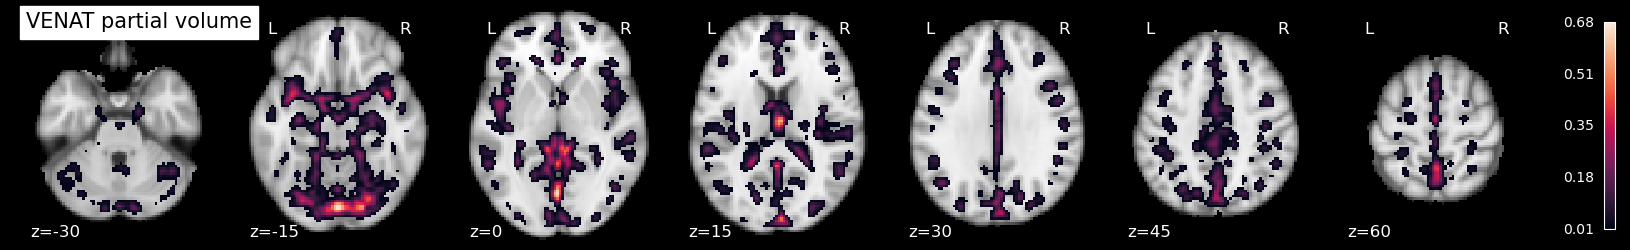

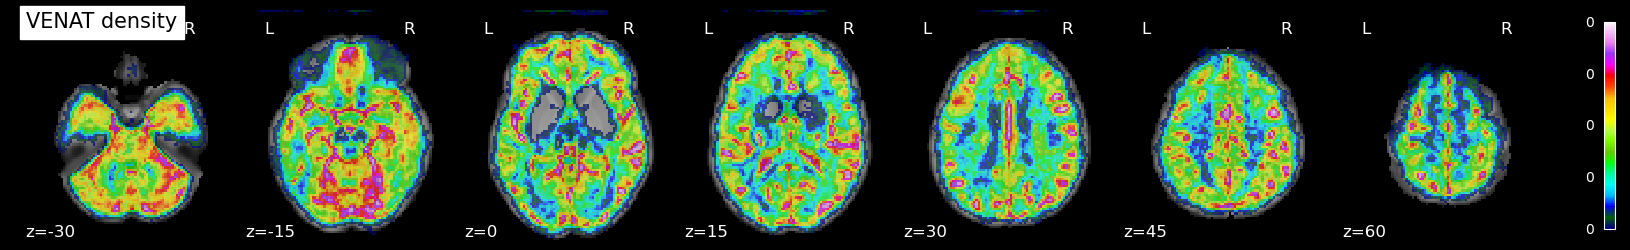

In [32]:
## first, coregister VENAT atlas to MNI space
VENAT_partial_volume = os.path.join(derivatives_dir, 'VENAT_PartialVolume.nii.gz')
VENAT_partial_volume_MNI2mm = os.path.join(derivatives_dir, 'VENAT_PartialVolume_MNI2mm.nii.gz')
! flirt -in {VENAT_partial_volume} -ref {VENAT_partial_volume} -applyisoxfm 2 -out {VENAT_partial_volume_MNI2mm}

VENAT_density = os.path.join(derivatives_dir,'VENAT_DensityMap.nii.gz') 
VENAT_density_MNI2mm = os.path.join(derivatives_dir, 'VENAT_DensityMap_MNI2mm.nii.gz')
! flirt -in {VENAT_density} -ref {VENAT_density} -applyisoxfm 2 -out {VENAT_density_MNI2mm}
! flirt -in {VENAT_density} -ref {MNI_2mm_brain} -out {VENAT_density_MNI2mm} -dof 6


plotting.plot_img(VENAT_partial_volume_MNI2mm, bg_img=MNI_2mm_brain, threshold=0.01, display_mode='z',colorbar=True, black_bg=True, 
                              title = ('VENAT partial volume'), cut_coords = (-30, -15, 0, 15, 30, 45, 60))

plotting.plot_roi(VENAT_density_MNI2mm, bg_img=MNI_2mm_brain, threshold=0.01, display_mode='z',  colorbar=True, black_bg=True, 
                              title = ('VENAT density'), cut_coords = (-30, -15, 0, 15, 30, 45, 60))

In [33]:
BOLD_ROI = 'all'

## create array of masks with all concordant and all discordant voxels ##
#################################################################
masks_concord=[]
masks_discord=[]
contrasts = ['calccontrol', 'memcontrol']
for contrast in contrasts:

    ## divide into: real deactivation and dissociation areas!
    PLS_true_deact = os.path.join(results_dir, 'negBOLD_negCMRO2_' + contrast + '.nii.gz') #negBOLD_negCMRO2_memcontrol_CMRO2deact
    #plotting.plot_img(PLS_true_deact, cmap=colormap,  bg_img=MNI_brain, threshold=0, display_mode='z')

    PLS_dissociation = os.path.join(results_dir, 'negBOLD_posCMRO2_' + contrast + '.nii.gz')
    #plotting.plot_img(PLS_dissociation, cmap=colormap,  bg_img=MNI_brain, threshold=0, display_mode='z')
    
    masks_concord.append(PLS_true_deact)
    masks_discord.append(PLS_dissociation)
    
    ## divide into: real deactivation and dissociation areas!
    PLS_true_act =  os.path.join(results_dir, 'posBOLD_posCMRO2_' + contrast + '.nii.gz')

    #plotting.plot_img(PLS_true_act, cmap=colormap,  bg_img=MNI_brain, threshold=0, display_mode='z')

    PLS_dissociation = os.path.join(results_dir, 'posBOLD_negCMRO2_' + contrast + '.nii.gz')
    #plotting.plot_img(PLS_dissociation, cmap=colormap,  bg_img=MNI_brain, threshold=0, display_mode='z')

    masks_concord.append(PLS_true_act)
    masks_discord.append(PLS_dissociation)


palette=['plum', 'darkviolet']

VENAT_density_MNI2mm = os.path.join(derivatives_dir, 'VENAT_DensityMap_MNI2mm.nii.gz')

mask_GM = results_dir + '/GM_vox_without_calccontrol_memcontrol_vox.nii.gz'
masker_GM = input_data.NiftiMasker(mask_img=mask_GM)
VENAT_values_GM = (np.squeeze(masker_GM.fit_transform(VENAT_density_MNI2mm)))


## fill with values
VENAT_values_true = []
for m,mask in enumerate(masks_concord):
    masker = input_data.NiftiMasker(mask_img=mask)
    VENAT_values_true.append(np.squeeze(masker.fit_transform(VENAT_density_MNI2mm)))
VENAT_values_true = np.array([item for sublist in VENAT_values_true for item in sublist])

VENAT_values_false = []
for m,mask in enumerate(masks_discord):
    masker = input_data.NiftiMasker(mask_img=mask)
    VENAT_values_false.append(np.squeeze(masker.fit_transform(VENAT_density_MNI2mm)))
VENAT_values_false = np.array([item for sublist in VENAT_values_false for item in sublist])

##kick out zeros and negative values
VENAT_values_true[VENAT_values_true<0]=np.nan
VENAT_values_false[VENAT_values_false<0]=np.nan

##permutation test, because data are smoothed/non-independent
## difference in medians
def statistic(VENAT_values_true, VENAT_values_false):
        return np.median(VENAT_values_true, axis=0) - np.median(VENAT_values_false, axis=0)
def statistic_gm(VENAT_values_GM, VENAT_values_false):
        return np.median(VENAT_values_GM, axis=0) - np.median(VENAT_values_false, axis=0)
    
result = stats.permutation_test((VENAT_values_true, VENAT_values_false), statistic, permutation_type='independent', n_resamples=2000, alternative='two-sided')
p_value = result.pvalue
print('permutation statistics true vs. false, ' + contrast + ' all concordant/discordant voxels'  + ' :' + str(round(p_value, 6)))

## put into dataframe
df_VENAT = pd.DataFrame()
df_VENAT['values'] = np.concatenate((VENAT_values_true, VENAT_values_false, VENAT_values_GM), axis=0)
df_VENAT['ROI'] = np.concatenate((len(VENAT_values_true)*['concordant'], len(VENAT_values_false)*['discordant'], len(VENAT_values_GM)*['GM']), axis=0)
    
df_VENAT_melted = pd.melt(df_VENAT, id_vars='ROI')


## plot barplots
fontsize=20
fig, ax = plt.subplots(1, figsize= (3,5))
sns.boxplot(x='ROI', y='value',  data=df_VENAT_melted, ax=ax, palette=palette, saturation=0.9,
                   boxprops={"edgecolor": (.6, .6, .6, .5)}, flierprops={"marker": "x"},
                   medianprops={"color": "black"})
#bar = sns.barplot(x='ROI', y='value',  data=df_VENAT_melted, ax=ax, palette=palette,  
#            estimator=np.median, ci=95, capsize=.05, n_boot=2000, errwidth=1, saturation=0.9, alpha=0.8) 
ax.hlines(np.nanmedian(VENAT_values_GM),-0.5, 1.5, color='grey', linestyle='dashed')

#ax.set_ylim(-0.6, 0.8)
#ax.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
#ax.set_ylim(-0.2, 1.25)
#ax.set_yticks([0, 0.25, 0.5, 0.75, 1, 1.25])
#ax.tick_params(axis='y', labelcolor=color)
ax.set_ylabel('venous density', fontsize = fontsize) 
ax.set_xlim([-0.5, 1.5]) 
ax.set_xticks([0, 1]) 
ax.set_xticklabels(['conc.', 'disc.']) 
ax.set_ylim(-0.1, 1)

if p_value < 0.001:
    ax.text(0.4, 1, '**', color='grey', fontsize=fontsize)
#ax.legend(fontsize=fontsize-5,loc="upper left")
#set x-tick and y-ticke label size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(fontsize)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.savefig(results_dir + '/VENAT_values_' + contrast + '_all_conc_discord_voxels.png', dpi=300, bbox_inches='tight')

fig.show()

permutation statistics true vs. false, memcontrol all concordant/discordant voxels :0.001


### QSM:human phantom data

In [34]:
BOLD_ROI = 'all'
QSM_MNI2mm = os.path.join( derivatives_dir, 'sub-yv98_ses-4088+4137_QSM_L2000-vsmv3_2mm.nii.gz')
plotting.plot_img(QSM_MNI2mm, bg_img=MNI_2mm_brain, threshold=0, colorbar=True, black_bg=True, 
                    cmap='jet', vmin=0, vmax=0.13, title = ('QSM'))

palette=['plum', 'darkviolet']

## fill with values
QSM_values_true = []
for m,mask in enumerate(masks_concord):
    masker = input_data.NiftiMasker(mask_img=mask)
    QSM_values_true.append(np.squeeze(masker.fit_transform(QSM_2mm)))
QSM_values_true = np.array([item for sublist in QSM_values_true for item in sublist])

QSM_values_false = []
for m,mask in enumerate(masks_discord):
    masker = input_data.NiftiMasker(mask_img=mask)
    QSM_values_false.append(np.squeeze(masker.fit_transform(QSM_2mm)))
QSM_values_false = np.array([item for sublist in QSM_values_false for item in sublist])

QSM_GM= []
mask_GM_woPLS = results_dir + '/GM_vox_without_calccontrol_memcontrol_vox.nii.gz'
masker_GM = input_data.NiftiMasker(mask_img=mask_GM_woPLS)
QSM_GM = np.squeeze(masker_GM.fit_transform(QSM_2mm))

##kick out zeros
QSM_GM[QSM_GM==0]=np.nan
QSM_values_true[QSM_values_true==0]=np.nan
QSM_values_false[QSM_values_false==0]=np.nan

##permutation test, because data are smoothed/non-independent
## difference in medians
def statistic(QSM_values_true, QSM_values_false):
        return np.median(QSM_values_true, axis=0) - np.median(QSM_values_false, axis=0)
def statistic_gm(QSM_GM, QSM_values_false):
        return np.median(QSM_GM, axis=0) - np.median(QSM_values_false, axis=0)
    
res_CALCneg = stats.permutation_test((QSM_values_true, QSM_values_false), statistic, permutation_type='independent', n_resamples=2000, alternative='two-sided')
p_true_false = res_CALCneg.pvalue
print('permutation statistics conc vs. disc. : ' + str(round(p_true_false, 6)))
res_GM = stats.permutation_test((QSM_GM, QSM_values_false), statistic_gm, permutation_type='independent', n_resamples=2000, alternative='two-sided')
p_GM_false = res_GM.pvalue
print('permutation statistics disc vs. GM: ' + str(round(p_GM_false, 6)))

## put into dataframe
df_QSM = pd.DataFrame()
df_QSM['values'] = np.concatenate((QSM_values_true, QSM_values_false, QSM_GM), axis=0)
df_QSM['ROI'] = np.concatenate((len(QSM_values_true)*['concordant'], len(QSM_values_false)*['discordant'], len(QSM_GM)*['GM']), axis=0)
    
#df_QSM_melted = pd.melt(df_QSM, id_vars='ROI')
GM_median = np.nanmedian(df_QSM.query(f"ROI=='GM'")['values'].values)



## plot barplots
fontsize=25
fig, ax = plt.subplots(1, figsize= (4,5))
#bar = sns.barplot(x='ROI', y='values',  data=df_QSM, ax=ax, palette=['plum', 'darkviolet'],  
#            estimator=np.median, ci=95, capsize=.05, n_boot=3000, errwidth=1, saturation=0.9, alpha=0.8) 

sns.boxplot(x='ROI', y='values',  data=df_QSM, ax=ax, palette=['plum', 'darkviolet'], 
                   boxprops={"edgecolor": (.6, .6, .6, .5)}, flierprops={"marker": "x"},
                   medianprops={"color": "black"})
#sns.violinplot(x='ROI', y='values',  data=df_QSM, ax=ax, palette=['plum', 'darkviolet'], 
#                   boxprops={"edgecolor": (.6, .6, .6, .5)}, flierprops={"marker": "x"},
#                   medianprops={"color": "black"})
ax.set_ylabel('susceptibility', fontsize = fontsize) 
ax.set_xlim([-0.5, 1.5]) 
ax.set_xticks([0, 1]) 
ax.set_xticklabels(['conc.', 'disc.']) 
ax.set_ylim([-0.025, 0.025]) 
ax.hlines(GM_median, -0.5, 1.5, color='gray', linestyle='--')

if p_true_false <= 0.001:
    ax.text(0.4, 0.025, '**', color='grey', fontsize=fontsize)
#ax.legend(fontsize=fontsize-5,loc="upper left")
#set x-tick and y-ticke label size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(fontsize)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.savefig(results_dir + '/QSM_values_all_conc_disc_voxels.png', dpi=300, bbox_inches='tight')

fig.show()


permutation statistics conc vs. disc. : 0.001
permutation statistics disc vs. GM: 0.001


## Fig. 4D: Task-effects; delta task responses delta CMRO2

In [52]:
## create discordant and concordant masks
pos_neg_disc_calc = os.path.join(results_dir, 'BOLD_CMRO2_discordant_calc'+baseline+'.nii.gz')
negBOLD_disc_calc = os.path.join(results_dir, 'negBOLD_posCMRO2_calc' +baseline+ '.nii.gz')
posBOLD_disc_calc = os.path.join(results_dir, 'posBOLD_negCMRO2_calc' +baseline+ '.nii.gz')
! fslmaths {negBOLD_disc_calc} -add {posBOLD_disc_calc} -bin {pos_neg_disc_calc}

pos_neg_disc_mem = os.path.join(results_dir, 'BOLD_CMRO2_discordant_mem'+baseline+'.nii.gz')
negBOLD_disc_mem = os.path.join(results_dir, 'negBOLD_posCMRO2_mem' +baseline+ '.nii.gz')
posBOLD_disc_mem = os.path.join(results_dir, 'posBOLD_negCMRO2_mem' +baseline+ '.nii.gz')
! fslmaths {negBOLD_disc_mem} -add {posBOLD_disc_mem} -bin {pos_neg_disc_mem}

pos_neg_conc_calc = os.path.join(results_dir, 'BOLD_CMRO2_concordant_calc'+baseline +'.nii.gz')
negBOLD_conc_calc = os.path.join(results_dir, 'negBOLD_negCMRO2_calc' +baseline+ '.nii.gz')
posBOLD_conc_calc = os.path.join(results_dir, 'posBOLD_posCMRO2_calc' +baseline+ '.nii.gz')
! fslmaths {negBOLD_conc_calc} -add {posBOLD_conc_calc} -bin {pos_neg_conc_calc}

pos_neg_conc_mem = os.path.join(results_dir,  'BOLD_CMRO2_concordant_mem'+baseline +'.nii.gz')    
negBOLD_conc_mem = os.path.join(results_dir, 'negBOLD_negCMRO2_mem' +baseline+ '.nii.gz')
posBOLD_conc_mem = os.path.join(results_dir, 'posBOLD_posCMRO2_mem' +baseline+ '.nii.gz')
! fslmaths {negBOLD_conc_mem} -add {posBOLD_conc_mem} -bin {pos_neg_conc_mem}

## only mem or calc condition / contrast
#disc_masks = [pos_neg_disc_mem]

#conc_masks = [pos_neg_conc_mem]

#task = ['mem']
#baseline = ['control']

## both calc and mem contrasts / regions
disc_masks = [pos_neg_disc_calc, pos_neg_disc_mem]
conc_masks = [pos_neg_conc_calc, pos_neg_conc_mem]

task = ['calc', 'mem']
baseline = 'control'

mask_types = ['concordant', 'discordant'] ## in both: first calc, then mem
conc_df_calc = pd.DataFrame()       
disc_df_mem = pd.DataFrame()
conc_df_mem = pd.DataFrame()       
disc_df_calc= pd.DataFrame()

for mask_type in mask_types: 
    print(mask_type)
    
    if mask_type == 'concordant':
        masks = conc_masks
    
    if mask_type == 'discordant':
        masks = disc_masks
        
    for m, mask in enumerate(masks):
        print(task[m])
        contrast = task[m] + baseline[0] ## first calc then mem 

        PLS_masker = input_data.NiftiMasker(mask_img = mask)
        len_mask =  len(np.argwhere(np.array(nib.load(mask).dataobj)))

        BOLD_percchange = np.zeros((len(sids_30), len_mask))
        CBV_baseline = np.zeros((len(sids_30),len_mask))
        CMRO2_base = np.zeros((len(sids_30), len_mask))
        OEF_base = np.zeros((len(sids_30), len_mask))
        CBF_base = np.zeros((len(sids_30), len_mask))
        CMRO2_task = np.zeros((len(sids_30), len_mask))
        OEF_task = np.zeros((len(sids_30), len_mask))
        CBF_task = np.zeros((len(sids_30), len_mask))
        CMRO2_delta = np.zeros((len(sids_30), len_mask))
        OEF_delta = np.zeros((len(sids_30), len_mask))
        CBF_delta= np.zeros((len(sids_30), len_mask))
        CMRO2_percchange = np.zeros((len(sids_30), len_mask))
        OEF_percchange = np.zeros((len(sids_30), len_mask))
        CBF_percchange= np.zeros((len(sids_30), len_mask))


        for i, ID in enumerate(sids_30): #loop over subjects
            sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
            print(sub)

            sub_dir = os.path.join(data_dir, sub)

            dir_anat = os.path.join(sub_dir, 'anat')
            dir_func = os.path.join(sub_dir, 'func')
            dir_perf = os.path.join(sub_dir, 'perf')

            dir_anat_deriv = os.path.join(derivatives_dir, sub, 'anat')
            dir_func_deriv = os.path.join(derivatives_dir, sub, 'func')
            dir_perf_deriv = os.path.join(derivatives_dir, sub, 'perf')
            dir_qmri_deriv = os.path.join(derivatives_dir, sub, 'qmri')


            #load baseline & task images
            base_CMRO2 = np.squeeze(PLS_masker.fit_transform( os.path.join(dir_qmri_deriv, sub + '_task-' + baseline + '_space-MNI152_desc-orig_cmro2.nii.gz')))
            base_OEF = np.squeeze(PLS_masker.fit_transform( os.path.join(dir_qmri_deriv, sub + '_task-' + baseline + '_space-MNI152_oef.nii.gz')))
            base_CBF = np.squeeze(PLS_masker.fit_transform(os.path.join(dir_qmri_deriv, sub + '_task-' + baseline + '_space-MNI152_cbf.nii.gz')))
            task_CBF = np.squeeze(PLS_masker.fit_transform(os.path.join(dir_qmri_deriv, sub + '_task-' + task[m] + '_space-MNI152_cbf.nii.gz')))
            if CMRO2_mode == 'orig' or task[m]!='calc': ## without CBV correction
                task_CMRO2 = np.squeeze(PLS_masker.fit_transform( os.path.join(dir_qmri_deriv, sub + '_task-' + task[m] + '_base-' + baseline + '_space-MNI152_desc-semi-quant_cmro2.nii.gz')))
                task_OEF = np.squeeze(PLS_masker.fit_transform( os.path.join(dir_qmri_deriv, sub + '_task-' + task[m] + '_base-' + baseline + '_space-MNI152_desc-semi-quant_oef.nii.gz')))                
            if CMRO2_mode == 'corrected' and task[m]=='calc': ## with CBV correction
                task_CMRO2 = np.squeeze(PLS_masker.fit_transform( os.path.join(dir_qmri_deriv, sub + '_task-' + task[m] + '_base-' + baseline +'_space-MNI152_desc-semi-quant-corrected_cmro2.nii.gz')))
                task_OEF = np.squeeze(PLS_masker.fit_transform( os.path.join(dir_qmri_deriv, sub + '_task-' + task[m] + '_base-' + baseline +'_space-MNI152_desc-semi-quant-corrected_oef.nii.gz')))

            percchange_CMRO2 = (task_CMRO2- base_CMRO2) / base_CMRO2 *100 
            percchange_CBF = (task_CBF- base_CBF) / base_CBF *100               
            percchange_OEF = (task_OEF- base_OEF) / base_OEF *100               
            delta_CMRO2 = task_CMRO2 - base_CMRO2
            delta_CBF = task_CBF - base_CBF
            delta_OEF = task_OEF - base_OEF
            CMRO2_base[i, :] = base_CMRO2
            OEF_base[i, :] = base_OEF
            CBF_base[i, :] = base_CBF/0.75
            CMRO2_task[i, :] = task_CMRO2
            OEF_task[i, :] = task_OEF
            CBF_task[i, :] = task_CBF/0.75
            CMRO2_delta[i, :] = delta_CMRO2
            OEF_delta[i, :] = delta_OEF
            CBF_delta[i, :] = delta_CBF/0.75
            CMRO2_percchange[i,:] = percchange_CMRO2
            OEF_percchange[i, :] = percchange_OEF
            CBF_percchange[i, :] = percchange_CBF


        ## create df
        if task[m] == 'calc':
            if mask_type == 'concordant':
                conc_df_calc['CMRO2_base'] = np.nanmedian(CMRO2_base, axis=0)
                conc_df_calc['OEF_base'] = np.nanmedian(OEF_base, axis=0)
                conc_df_calc['CBF_base' ] = np.nanmedian(CBF_base, axis=0)
                conc_df_calc['CMRO2_task' ] = np.nanmedian(CMRO2_task, axis=0)
                conc_df_calc['OEF_task' ] = np.nanmedian(OEF_task, axis=0)
                conc_df_calc['CBF_task' ] = np.nanmedian(CBF_task, axis=0)
                conc_df_calc['CMRO2_delta'] = np.nanmedian(CMRO2_delta, axis=0)
                conc_df_calc['OEF_delta' ] = np.nanmedian(OEF_delta, axis=0)
                conc_df_calc['CBF_delta'] = np.nanmedian(CBF_delta, axis=0)
                conc_df_calc['CMRO2_percchange' ] = np.nanmedian(CMRO2_percchange, axis=0)
                conc_df_calc['OEF_percchange' ] = np.nanmedian(OEF_percchange, axis=0)
                conc_df_calc['CBF_percchange' ] = np.nanmedian(CBF_percchange, axis=0)   
            if mask_type == 'discordant':
                disc_df_calc['CMRO2_base' ] = np.nanmedian(CMRO2_base, axis=0)
                disc_df_calc['OEF_base' ] = np.nanmedian(OEF_base, axis=0)
                disc_df_calc['CBF_base' ] = np.nanmedian(CBF_base, axis=0)
                disc_df_calc['CMRO2_task' ] = np.nanmedian(CMRO2_task, axis=0)
                disc_df_calc['OEF_task' ] = np.nanmedian(OEF_task, axis=0)
                disc_df_calc['CBF_task' ] = np.nanmedian(CBF_task, axis=0)
                disc_df_calc['CMRO2_delta'] = np.nanmedian(CMRO2_delta, axis=0)
                disc_df_calc['OEF_delta' ] = np.nanmedian(OEF_delta, axis=0)
                disc_df_calc['CBF_delta' ] = np.nanmedian(CBF_delta, axis=0)
                disc_df_calc['CMRO2_percchange' ] = np.nanmedian(CMRO2_percchange, axis=0)
                disc_df_calc['OEF_percchange' ] = np.nanmedian(OEF_percchange, axis=0)
                disc_df_calc['CBF_percchange' ] = np.nanmedian(CBF_percchange, axis=0)
        if task[m] == 'mem':
            if mask_type == 'concordant':
                conc_df_mem['CMRO2_base'] = np.nanmedian(CMRO2_base, axis=0)
                conc_df_mem['OEF_base'] = np.nanmedian(OEF_base, axis=0)
                conc_df_mem['CBF_base' ] = np.nanmedian(CBF_base, axis=0)
                conc_df_mem['CMRO2_task' ] = np.nanmedian(CMRO2_task, axis=0)
                conc_df_mem['OEF_task' ] = np.nanmedian(OEF_task, axis=0)
                conc_df_mem['CBF_task' ] = np.nanmedian(CBF_task, axis=0)
                conc_df_mem['CMRO2_delta'] = np.nanmedian(CMRO2_delta, axis=0)
                conc_df_mem['OEF_delta' ] = np.nanmedian(OEF_delta, axis=0)
                conc_df_mem['CBF_delta'] = np.nanmedian(CBF_delta, axis=0)
                conc_df_mem['CMRO2_percchange'] = np.nanmedian(CMRO2_percchange, axis=0)
                conc_df_mem['OEF_percchange'] = np.nanmedian(OEF_percchange, axis=0)
                conc_df_mem['CBF_percchange'] = np.nanmedian(CBF_percchange, axis=0)   
            if mask_type == 'discordant':
                disc_df_mem['CMRO2_base' ] = np.nanmedian(CMRO2_base, axis=0)
                disc_df_mem['OEF_base' ] = np.nanmedian(OEF_base, axis=0)
                disc_df_mem['CBF_base' ] = np.nanmedian(CBF_base, axis=0)
                disc_df_mem['CMRO2_task' ] = np.nanmedian(CMRO2_task, axis=0)
                disc_df_mem['OEF_task' ] = np.nanmedian(OEF_task, axis=0)
                disc_df_mem['CBF_task'] = np.nanmedian(CBF_task, axis=0)
                disc_df_mem['CMRO2_delta'] = np.nanmedian(CMRO2_delta, axis=0)
                disc_df_mem['OEF_delta' ] = np.nanmedian(OEF_delta, axis=0)
                disc_df_mem['CBF_delta' ] = np.nanmedian(CBF_delta, axis=0)
                disc_df_mem['CMRO2_percchange' ] = np.nanmedian(CMRO2_percchange, axis=0)
                disc_df_mem['OEF_percchange' ] = np.nanmedian(OEF_percchange, axis=0)
                disc_df_mem['CBF_percchange' ] = np.nanmedian(CBF_percchange, axis=0)

concordant
calc
sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
mem
sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
discordant
calc
sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
mem
sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p0

TypeError: regplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 3 keyword-only arguments) were given

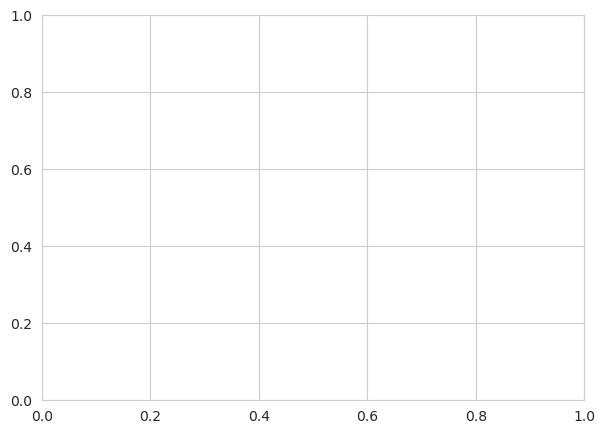

In [53]:
## mask voxels with CMRO2 300 and OEF > 1  ##
################################################
if len(task)==1 and task[0]=='calc':
    conc_df_calc = conc_df_calc.drop(conc_df_calc[conc_df_calc['CMRO2_base' ]> 300].index)
    conc_df_calc = conc_df_calc.drop(conc_df_calc[conc_df_calc['OEF_base' ] > 1].index)
    conc_df_calc = conc_df_calc.drop(conc_df_calc[conc_df_calc['OEF_base'] == 0 ].index)
    conc_df_calc = conc_df_calc.drop(conc_df_calc[conc_df_calc['CMRO2_base' ] == 0 ].index)

    disc_df_calc = disc_df_calc.drop(disc_df_calc[disc_df_calc['CMRO2_base' ]> 300].index)
    disc_df_calc = disc_df_calc.drop(disc_df_calc[disc_df_calc['OEF_base' ] > 1].index)
    disc_df_calc = disc_df_calc.drop(disc_df_calc[disc_df_calc['OEF_base'] == 0 ].index)
    disc_df_calc = disc_df_calc.drop(disc_df_calc[disc_df_calc['CMRO2_base' ] == 0 ].index)
    
##apply same to discordant voxels
if len(task)==1 and task[0]=='mem':
    conc_df_mem = conc_df_mem.drop(conc_df_mem[conc_df_mem['CMRO2_base' ] > 300].index)
    conc_df_mem = conc_df_mem.drop(conc_df_mem[conc_df_mem['OEF_base' ] > 1].index)
    conc_df_mem = conc_df_mem.drop(conc_df_mem[conc_df_mem['OEF_base' ] == 0 ].index)
    conc_df_mem = conc_df_mem.drop(conc_df_mem[conc_df_mem['CMRO2_base' ] == 0 ].index)
    
    disc_df_mem = disc_df_mem.drop(disc_df_mem[disc_df_mem['CMRO2_base' ] > 300].index)
    disc_df_mem = disc_df_mem.drop(disc_df_mem[disc_df_mem['OEF_base' ] > 1].index)
    disc_df_mem = disc_df_mem.drop(disc_df_mem[disc_df_mem['OEF_base' ] == 0 ].index)
    disc_df_mem = disc_df_mem.drop(disc_df_mem[disc_df_mem['CMRO2_base' ] == 0 ].index)

if len(task)==2:
    conc_df_mem = conc_df_mem.drop(conc_df_mem[conc_df_mem['CMRO2_base' ] > 300].index)
    conc_df_mem = conc_df_mem.drop(conc_df_mem[conc_df_mem['OEF_base' ] > 1].index)
    conc_df_mem = conc_df_mem.drop(conc_df_mem[conc_df_mem['OEF_base' ] == 0 ].index)
    conc_df_mem = conc_df_mem.drop(conc_df_mem[conc_df_mem['CMRO2_base' ] == 0 ].index)
    
    conc_df_calc = conc_df_calc.drop(conc_df_mem[conc_df_mem['CMRO2_base' ] > 300].index)
    conc_df_calc = conc_df_calc.drop(conc_df_mem[conc_df_mem['OEF_base' ] > 1].index)
    conc_df_calc = conc_df_calc.drop(conc_df_mem[conc_df_mem['OEF_base' ] == 0 ].index)
    conc_df_calc = conc_df_calc.drop(conc_df_mem[conc_df_mem['CMRO2_base' ] == 0 ].index)
    
    disc_df_mem = disc_df_mem.drop(disc_df_mem[disc_df_mem['CMRO2_base' ] > 300].index)
    disc_df_mem = disc_df_mem.drop(disc_df_mem[disc_df_mem['OEF_base' ] > 1].index)
    disc_df_mem = disc_df_mem.drop(disc_df_mem[disc_df_mem['OEF_base' ] == 0 ].index)
    disc_df_mem = disc_df_mem.drop(disc_df_mem[disc_df_mem['CMRO2_base' ] == 0 ].index)

    disc_df_calc= disc_df_calc.drop(disc_df_mem[disc_df_mem['CMRO2_base' ] > 300].index)
    disc_df_calc = disc_df_calc.drop(disc_df_mem[disc_df_mem['OEF_base' ] > 1].index)
    disc_df_calc = disc_df_calc.drop(disc_df_mem[disc_df_mem['OEF_base' ] == 0 ].index)
    disc_df_calc = disc_df_calc.drop(disc_df_mem[disc_df_mem['CMRO2_base' ] == 0 ].index)
    
## condordant vs. discordant voxels percchange ##
################################################

colors = ["darkviolet", "darkviolet"]
Violet = LinearSegmentedColormap.from_list("mycmap", colors)


### percchange CBF vs. percchange OEF
    
fig, ax = plt.subplots(1, figsize=(7, 5))

if len(task)==1 and task[0] == 'mem':
    dataframe_con = conc_df_mem
    dataframe_disc = disc_df_mem
if len(task)==1 and task[0] == 'calc':
    dataframe_con = conc_df_calc
    dataframe_disc = disc_df_calc
if len(task)==1:
    sns.regplot(dataframe_con['CBF_percchange' ], dataframe_con['OEF_percchange'], ax=ax, color='plum', scatter_kws={'s':1})
    (r, p) = stats.pearsonr(dataframe_con['CBF_percchange'], dataframe_con['OEF_percchange'])
    ax.text(5, 10, 'r= ' + str(round(r, 2)), fontsize=fontsize, color='plum')    
    scatter = ax.scatter(dataframe_con['CBF_percchange'], dataframe_con['OEF_percchange'], c='plum', s=2,  vmin = -20, vmax=20, label='condordant')

    sns.regplot(dataframe_disc['CBF_percchange'], dataframe_disc['OEF_percchange'], ax=ax, color='darkviolet', scatter_kws={'s':1})
    (r, p) = stats.pearsonr(dataframe_disc['CBF_percchange'], dataframe_disc['OEF_percchange'])
    ax.text(15, 10, 'r= ' + str(round(r, 2)), fontsize=fontsize, color='darkviolet')    
    scatter = ax.scatter(dataframe_disc['CBF_percchange'], dataframe_disc['OEF_percchange'], c='darkviolet', s=2, vmin = -20, vmax=20, label='discordant')

if len(task)==2:
    sns.regplot(np.append(conc_df_calc['CBF_percchange' ], conc_df_mem['CBF_percchange']), np.append(conc_df_calc['OEF_percchange'], conc_df_mem['OEF_percchange']), ax=ax, color='plum', scatter_kws={'s':1})
    (r, p) = stats.pearsonr(np.append(conc_df_calc['CBF_percchange' ], conc_df_mem['CBF_percchange' ]), np.append(conc_df_calc['OEF_percchange'], conc_df_mem['OEF_percchange']))
    ax.text(5, 10, 'r= ' + str(round(r, 2)), fontsize=fontsize, color='plum')    
    scatter = ax.scatter(np.append(conc_df_calc['CBF_percchange' ], conc_df_mem['CBF_percchange' ]), np.append(conc_df_calc['OEF_percchange'], conc_df_mem['OEF_percchange']), c='plum', s=2,  vmin = -20, vmax=20, label='condordant')

    sns.regplot(np.append(disc_df_calc['CBF_percchange'], disc_df_mem['CBF_percchange']), np.append(disc_df_calc['OEF_percchange'], disc_df_mem['OEF_percchange']), ax=ax, color='darkviolet', scatter_kws={'s':1})
    (r, p) = stats.pearsonr(np.append(disc_df_calc['CBF_percchange'], disc_df_mem['CBF_percchange']), np.append(disc_df_calc['OEF_percchange'], disc_df_mem['OEF_percchange']))
    ax.text(15, 10, 'r= ' + str(round(r, 2)), fontsize=fontsize, color='darkviolet')    
    scatter = ax.scatter(np.append(disc_df_calc['CBF_percchange'], disc_df_mem['CBF_percchange']), np.append(disc_df_calc['OEF_percchange'], disc_df_mem['OEF_percchange']), c='darkviolet', s=2, vmin = -20, vmax=20, label='discordant')
    
ax.legend(loc='upper left', fontsize='x-large', markerscale=10)

ax.set_xlabel('ΔCBF [%]', fontsize=fontsize)
ax.set_ylabel('ΔOEF [%]', fontsize=fontsize)
ax.set_ylim(-15, 15)
ax.set_xlim(-15, 25)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)
        #ax.set_title('coupling CBF/BOLD, CMRO2/BOLD')

for pos in ['right', 'top']:
            ax.spines[pos].set_visible(False)
        
fig.savefig(results_dir + '/N' + N_subj + '_BOLDall_disc_concord_percchange_CBF_OEF.png', dpi=300, bbox_inches='tight')
fig.show() 
    
### percchange CMRO2 vs. percchange OEF

fig, ax = plt.subplots(1, figsize=(7, 5))

if len(task)==1 and task[0] == 'mem':
    dataframe_con = conc_df_mem
    dataframe_disc = disc_df_mem
if len(task)==1 and task[0] == 'calc':
    dataframe_con = conc_df_calc
    dataframe_disc = disc_df_calc
if len(task)==1:
    sns.regplot(dataframe_con['CMRO2_percchange'], dataframe_con['OEF_percchange'], ax=ax, color='plum', scatter_kws={'s':1}, label='condordant')
    (r, p) = stats.pearsonr(dataframe_con['CMRO2_percchange'], dataframe_con['OEF_percchange'])
    if p < 0.001:
        ax.text(15, -10, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='plum')    
    scatter = ax.scatter(dataframe_con['CMRO2_percchange'], dataframe_con['OEF_percchange'], c='plum', s=2,  vmin = -5, vmax=5)

    sns.regplot(dataframe_disc['CMRO2_percchange'], dataframe_disc['OEF_percchange'], ax=ax, color='darkviolet', scatter_kws={'s':1}, label='discordant')
    (r, p) = stats.pearsonr(dataframe_disc['CMRO2_percchange'], dataframe_disc['OEF_percchange'])
    if p < 0.001:
        ax.text(15, 13, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='darkviolet')    
    scatter = ax.scatter(dataframe_disc['CMRO2_percchange'], dataframe_disc['OEF_percchange'], c='darkviolet', s=2,  vmin = -5, vmax=5)

if len(task)==2:
    sns.regplot(np.append(conc_df_calc['CMRO2_percchange'], conc_df_mem['CMRO2_percchange']), np.append(conc_df_calc['OEF_percchange'],conc_df_mem['OEF_percchange']), ax=ax, color='plum', scatter_kws={'s':1}, label='condordant')
    (r, p) = stats.pearsonr(np.append(conc_df_calc['CMRO2_percchange'], conc_df_mem['CMRO2_percchange']), np.append(conc_df_calc['OEF_percchange'],conc_df_mem['OEF_percchange']))
    if p < 0.001:
        ax.text(15, -10, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='plum')    
    scatter = ax.scatter(np.append(conc_df_calc['CMRO2_percchange'], conc_df_mem['CMRO2_percchange']), np.append(conc_df_calc['OEF_percchange'],conc_df_mem['OEF_percchange']), c='plum', s=2,  vmin = -5, vmax=5)

    sns.regplot(np.append(disc_df_calc['CMRO2_percchange'], disc_df_mem['CMRO2_percchange']), np.append(disc_df_calc['OEF_percchange'], disc_df_mem['OEF_percchange']), ax=ax, color='darkviolet', scatter_kws={'s':1}, label='discordant')
    (r, p) = stats.pearsonr(np.append(disc_df_calc['CMRO2_percchange'], disc_df_mem['CMRO2_percchange']), np.append(disc_df_calc['OEF_percchange'], disc_df_mem['OEF_percchange']))
    if p < 0.001:
        ax.text(15, 13, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='darkviolet')    
    scatter = ax.scatter(np.append(disc_df_calc['CMRO2_percchange'], disc_df_mem['CMRO2_percchange']), np.append(disc_df_calc['OEF_percchange'], disc_df_mem['OEF_percchange']), c='darkviolet', s=2,  vmin = -5, vmax=5)
    
ax.legend(loc='upper left', fontsize='x-large', markerscale=10)
ax.set_xlabel('ΔCMRO2 [%]', fontsize=fontsize)
ax.set_ylabel('ΔOEF [%]', fontsize=fontsize)
ax.set_ylim(-15, 15)
ax.set_xlim(-15, 25)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)
        #ax.set_title('coupling CBF/BOLD, CMRO2/BOLD')

for pos in ['right', 'top']:
            ax.spines[pos].set_visible(False)
        
fig.savefig(results_dir + '/N' + N_subj + '_BOLDall_disc_concord_percchange_OEF_CMRO2.png', dpi=300, bbox_inches='tight')
fig.show()

### percchange CMRO2 vs. percchange CBF

fig, ax = plt.subplots(1, figsize=(7, 5))
if len(task)==1 and task[0] == 'mem':
    dataframe_con = conc_df_mem
    dataframe_disc = disc_df_mem
if len(task)==1 and task[0] == 'calc':
    dataframe_con = conc_df_calc
    dataframe_disc = disc_df_calc
if len(task)==1:
    sns.regplot(dataframe_con['CMRO2_percchange'], dataframe_con['CBF_percchange'], ax=ax, color='plum', scatter_kws={'s':1})
    (r, p) = stats.pearsonr(dataframe_con['CMRO2_percchange'], dataframe_con['CBF_percchange'])
    if p < 0.001:
        ax.text(18, 18, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='plum')    
    scatter = ax.scatter(dataframe_con['CMRO2_percchange'], dataframe_con['CBF_percchange'], c='plum', s=2,  vmin = -0.04, vmax=0.04, label='concordant')

    sns.regplot(dataframe_disc['CMRO2_percchange'], dataframe_disc['CBF_percchange'], ax=ax, color='darkviolet', scatter_kws={'s':1})
    (r, p) = stats.pearsonr(dataframe_disc['CMRO2_percchange'], dataframe_disc['CBF_percchange'])
    if p < 0.001:
        ax.text(18, 3, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='darkviolet')    
    scatter = ax.scatter(dataframe_disc['CMRO2_percchange'], dataframe_disc['CBF_percchange'], c='darkviolet', s=2, vmin = -0.04, vmax=0.04,label='discordant')

if len(task)==2:

    sns.regplot(np.append(conc_df_calc['CMRO2_percchange'], conc_df_mem['CMRO2_percchange']), np.append(conc_df_calc['CBF_percchange'], conc_df_mem['CBF_percchange']), ax=ax, color='plum', scatter_kws={'s':1})
    (r, p) = stats.pearsonr(np.append(conc_df_calc['CMRO2_percchange'], conc_df_mem['CMRO2_percchange']), np.append(conc_df_calc['CBF_percchange'], conc_df_mem['CBF_percchange']))
    if p < 0.001:
        ax.text(18, 18, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='plum')    
    scatter = ax.scatter(np.append(conc_df_calc['CMRO2_percchange'], conc_df_mem['CMRO2_percchange']), np.append(conc_df_calc['CBF_percchange'], conc_df_mem['CBF_percchange']), c='plum', s=2,  vmin = -0.04, vmax=0.04, label='concordant')

    sns.regplot(np.append(disc_df_calc['CMRO2_percchange'],disc_df_mem['CMRO2_percchange']), np.append(disc_df_calc['CBF_percchange'],disc_df_mem['CBF_percchange']), ax=ax, color='darkviolet', scatter_kws={'s':1})
    (r, p) = stats.pearsonr(np.append(disc_df_calc['CMRO2_percchange'],disc_df_mem['CMRO2_percchange']), np.append(disc_df_calc['CBF_percchange'],disc_df_mem['CBF_percchange']))
    if p < 0.001:
        ax.text(18, 3, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='darkviolet')    
    scatter = ax.scatter(np.append(disc_df_calc['CMRO2_percchange'],disc_df_mem['CMRO2_percchange']), np.append(disc_df_calc['CBF_percchange'],disc_df_mem['CBF_percchange']), c='darkviolet', s=2, vmin = -0.04, vmax=0.04,label='discordant')

ax.legend(loc='upper left', fontsize='x-large', markerscale=10)
ax.set_xlabel('ΔCMRO2 [%]', fontsize=fontsize)
ax.set_ylabel('ΔCBF [%]', fontsize=fontsize)
ax.set_ylim(-15, 25)
ax.set_xlim(-15, 25)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)
        #ax.set_title('coupling CBF/BOLD, CMRO2/BOLD')

for pos in ['right', 'top']:
            ax.spines[pos].set_visible(False)
        
fig.savefig(results_dir + '/N' + N_subj + '_BOLDall_disc_concord_percchange_CBF_CMRO2.png', dpi=300, bbox_inches='tight')
fig.show()

#### delta CMRO2 vs. delta CBV - for N=10 subjects and calc only

In [ ]:
## create discordant and concordant masks
pos_neg_disc_calc = os.path.join(results_dir, 'BOLD_CMRO2_discordant_calc'+baseline+'.nii.gz')

pos_neg_conc_calc = os.path.join(results_dir, 'BOLD_CMRO2_concordant_calc'+baseline +'.nii.gz')

sids_CBV = [58, 59, 60, 61, 63, 64, 65, 66, 67, 68]


## both calc and mem contrasts / regions
disc_masks = [pos_neg_disc_calc]
conc_masks = [pos_neg_conc_calc]

task = ['calc']
baseline = 'control'

mask_types = ['concordant', 'discordant'] ## in both: first calc, then mem
conc_df_calc_N10 = pd.DataFrame()          
disc_df_calc_N10 = pd.DataFrame()

for mask_type in mask_types: 
    print(mask_type)
    
    if mask_type == 'concordant':
        masks = conc_masks
    
    if mask_type == 'discordant':
        masks = disc_masks
        
    for m, mask in enumerate(masks):
        print(task[m])
        contrast = task[m] + baseline[0] ## first calc then mem 

        PLS_masker = input_data.NiftiMasker(mask_img = mask)
        len_mask =  len(np.argwhere(np.array(nib.load(mask).dataobj)))

        CBV_base = np.zeros((len(sids_CBV),len_mask))
        CBV_task = np.zeros((len(sids_CBV),len_mask))
        CBV_percchange = np.zeros((len(sids_CBV),len_mask))
        CMRO2_base = np.zeros((len(sids_CBV), len_mask))
        CMRO2_task = np.zeros((len(sids_CBV), len_mask))
        CMRO2_percchange = np.zeros((len(sids_CBV), len_mask))


        for i, ID in enumerate(sids_CBV): #loop over subjects
            sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
            print(sub)

            sub_dir = os.path.join(data_dir, sub)

            dir_anat = os.path.join(sub_dir, 'anat')
            dir_func = os.path.join(sub_dir, 'func')
            dir_perf = os.path.join(sub_dir, 'perf')

            dir_qmri_deriv = os.path.join(derivatives_dir, sub, 'qmri')


            #load baseline & task images
            base_CMRO2 = np.squeeze(PLS_masker.fit_transform( os.path.join(dir_qmri_deriv, sub + '_task-' + baseline + '_space-MNI152_desc-orig_cmro2.nii.gz')))
            base_CBV = np.squeeze(PLS_masker.fit_transform(os.path.join(dir_qmri_deriv, sub + '_task-' + baseline + '_space-MNI152_cbv.nii.gz')))
            task_CBV = np.squeeze(PLS_masker.fit_transform(os.path.join(dir_qmri_deriv, sub + '_task-' + task[m] + '_space-MNI152_cbv.nii.gz')))
            if CMRO2_mode == 'orig' or task[m]!='calc': ## without CBV correction
                task_CMRO2 = np.squeeze(PLS_masker.fit_transform( os.path.join(dir_qmri_deriv, sub + '_task-' + task[m] + '_base-' + baseline + '_space-MNI152_desc-semi-quant_cmro2.nii.gz')))
            if CMRO2_mode == 'corrected' and task[m]=='calc': ## with CBV correction
                task_CMRO2 = np.squeeze(PLS_masker.fit_transform( os.path.join(dir_qmri_deriv, sub + '_task-' + task[m] + '_base-' + baseline +'_space-MNI152_desc-semi-quant-corrected_cmro2.nii.gz')))

            percchange_CMRO2 = (task_CMRO2- base_CMRO2) / base_CMRO2 *100 
            percchange_CBV = (task_CBV- base_CBV) / base_CBV *100               
            CBV_percchange[i, :] = percchange_CBV
            CMRO2_percchange[i, :] = percchange_CMRO2
            CMRO2_base[i, :] = base_CMRO2
            CBV_base[i, :] = base_CBV
            CMRO2_task[i, :] = task_CMRO2
            CBV_task[i, :] = task_CBV

        ## create df
        if task[m] == 'calc':
            if mask_type == 'concordant':
                conc_df_calc_N10['CMRO2_base'] = np.nanmedian(CMRO2_base, axis=0)
                conc_df_calc_N10['CBV_base'] = np.nanmedian(CBV_base, axis=0)
                conc_df_calc_N10['CMRO2_task'] = np.nanmedian(CMRO2_task, axis=0)
                conc_df_calc_N10['CBV_task'] = np.nanmedian(CBV_task, axis=0)                
                conc_df_calc_N10['CMRO2_percchange' ] = np.nanmedian(CMRO2_percchange, axis=0)
                conc_df_calc_N10['CBV_percchange' ] = np.nanmedian(CBV_percchange, axis=0)
            if mask_type == 'discordant':
                disc_df_calc_N10['CMRO2_base'] = np.nanmedian(CMRO2_base, axis=0)
                disc_df_calc_N10['CBV_base'] = np.nanmedian(CBV_base, axis=0)
                disc_df_calc_N10['CMRO2_task'] = np.nanmedian(CMRO2_task, axis=0)
                disc_df_calc_N10['CBV_task'] = np.nanmedian(CBV_task, axis=0)                
                disc_df_calc_N10['CMRO2_percchange' ] = np.nanmedian(CMRO2_percchange, axis=0)
                disc_df_calc_N10['CBV_percchange' ] = np.nanmedian(CBV_percchange, axis=0)

In [ ]:
## mask voxels with CMRO2 300 ##
################################################
conc_df_calc_N10 = conc_df_calc_N10.drop(conc_df_calc_N10[conc_df_calc_N10['CMRO2_base' ]> 300].index)
conc_df_calc_N10 = conc_df_calc_N10.drop(conc_df_calc_N10[conc_df_calc_N10['CMRO2_base' ] == 0 ].index)

disc_df_calc_N10 = disc_df_calc_N10.drop(disc_df_calc_N10[disc_df_calc_N10['CMRO2_base' ]> 300].index)
disc_df_calc_N10 = disc_df_calc_N10.drop(disc_df_calc_N10[disc_df_calc_N10['CMRO2_base' ] == 0 ].index)
    

    
## condordant vs. discordant voxels percchange ##
################################################

colors = ["darkviolet", "darkviolet"]
Violet = LinearSegmentedColormap.from_list("mycmap", colors)


### percchange CBF vs. percchange OEF
    
fig, ax = plt.subplots(1, figsize=(7, 5))

dataframe_con = conc_df_calc_N10
dataframe_disc = disc_df_calc_N10

sns.regplot(dataframe_con['CMRO2_percchange' ], dataframe_con['CBV_percchange'], ax=ax, color='plum', scatter_kws={'s':1})
(r, p) = stats.pearsonr(dataframe_con['CMRO2_percchange'], dataframe_con['CBV_percchange'])
if p < 0.001:
    ax.text(11, 13, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='plum')    
scatter = ax.scatter(dataframe_con['CMRO2_percchange'], dataframe_con['CBV_percchange'], c='plum', s=2,  vmin = -20, vmax=20, label='condordant')

sns.regplot(dataframe_disc['CMRO2_percchange'], dataframe_disc['CBV_percchange'], ax=ax, color='darkviolet', scatter_kws={'s':1})
(r, p) = stats.pearsonr(dataframe_disc['CMRO2_percchange'], dataframe_disc['CBV_percchange'])
if p < 0.001:
    ax.text(11, 8, '**r= ' + str(round(r, 2)), fontsize=fontsize, color='darkviolet')    
scatter = ax.scatter(dataframe_disc['CMRO2_percchange'], dataframe_disc['CBV_percchange'], c='darkviolet', s=2, vmin = -20, vmax=20, label='discordant')

    
ax.legend(loc='upper left', fontsize='x-large', markerscale=10)

ax.set_xlabel('ΔCMRO2 [%]', fontsize=fontsize)
ax.set_ylabel('ΔCBV [%]', fontsize=fontsize)
ax.set_ylim(-15, 15)
ax.set_xlim(-15, 25)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)
        #ax.set_title('coupling CBF/BOLD, CMRO2/BOLD')

#for pos in ['right', 'top']:
#            ax.spines[pos].set_visible(False)
        
fig.savefig(results_dir + '/N10_BOLDall_disc_concord_percchange_CMRO2_CBV.png', dpi=300, bbox_inches='tight')
fig.show() 
    

### Multiple regression

#### concordant voxels

In [54]:
import pingouin as pg

## concordant voxels

## center predictors beforehands: 
df_conc_delta_vox_centered = pd.DataFrame()
df_conc_delta_vox_centered['CMRO2'] = np.append(conc_df_calc['CMRO2_percchange'], conc_df_mem['CMRO2_percchange'])
df_conc_delta_vox_centered['rOEF'] =  np.append(conc_df_calc['OEF_percchange'], conc_df_mem['OEF_percchange']) - np.nanmean(np.append(conc_df_calc['OEF_percchange'], conc_df_mem['OEF_percchange']))
df_conc_delta_vox_centered['CBF'] = np.append(conc_df_calc['CBF_percchange'], conc_df_mem['CBF_percchange']) - np.nanmean(np.append(conc_df_calc['CBF_percchange'], conc_df_mem['CBF_percchange']))

x = df_conc_delta_vox_centered[['rOEF', 'CBF']].dropna()
y = df_conc_delta_vox_centered['CMRO2'].dropna()

lm = pg.linear_regression(x,y, as_dataframe=False)

print('R2 = ' + str(lm['r2']))
print('beta values intercept, OEF, CBF = ' + str(lm['coef']))
print('p-values OEF, CBF = ' + str(lm['pval']))
print('df = ' + str(lm['df_resid']))

##Get the relative importance of predictors
lm = pg.linear_regression(x, y, remove_na=True, relimp=True)
lm[['names', 'relimp', 'relimp_perc']]

R2 = 0.8608819727011594
beta values intercept, OEF, CBF = [2.55501815 0.83437781 0.86398286]
p-values OEF, CBF = [0. 0. 0.]
df = 21971


names    relimp  relimp_perc
0  Intercept       NaN          NaN
1       rOEF  0.136728    15.882348
2        CBF  0.724154    84.117652

In [55]:
from statsmodels.formula.api import ols

## concordant voxels

model = ols('CMRO2 ~ rOEF + CBF', data=df_conc_delta_vox_centered).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  CMRO2   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                 6.798e+04
Date:                Wed, 31 Jan 2024   Prob (F-statistic):               0.00
Time:                        18:29:53   Log-Likelihood:                -41836.
No. Observations:               21974   AIC:                         8.368e+04
Df Residuals:                   21971   BIC:                         8.370e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5550      0.011    233.189      0.0

#### discordant voxels

In [56]:
## discordant voxels

## center predictors beforehands: 
df_disc_delta_vox_centered = pd.DataFrame()
df_disc_delta_vox_centered['CMRO2'] = np.append(disc_df_calc['CMRO2_percchange'], disc_df_mem['CMRO2_percchange'])
df_disc_delta_vox_centered['rOEF'] =  np.append(disc_df_calc['OEF_percchange'], disc_df_mem['OEF_percchange']) - np.nanmean(np.append(disc_df_calc['OEF_percchange'], disc_df_mem['OEF_percchange']))
df_disc_delta_vox_centered['CBF'] = np.append(disc_df_calc['CBF_percchange'], disc_df_mem['CBF_percchange']) - np.nanmean(np.append(disc_df_calc['CBF_percchange'], disc_df_mem['CBF_percchange']))

x = df_disc_delta_vox_centered[['rOEF', 'CBF']].dropna()
y = df_disc_delta_vox_centered['CMRO2'].dropna()

lm = pg.linear_regression(x,y, as_dataframe=False)

print('R2 = ' + str(lm['r2']))
print('beta values intercept, OEF, CBF = ' + str(lm['coef']))
print('p-values OEF, CBF = ' + str(lm['pval']))
print('df = ' + str(lm['df_resid']))

##Get the relative importance of predictors
lm = pg.linear_regression(x, y, remove_na=True, relimp=True)
lm[['names', 'relimp', 'relimp_perc']]

R2 = 0.8425617424473401
beta values intercept, OEF, CBF = [1.1884269  1.07086873 0.88473903]
p-values OEF, CBF = [0. 0. 0.]
df = 14694


names    relimp  relimp_perc
0  Intercept       NaN          NaN
1       rOEF  0.488253    57.948649
2        CBF  0.354309    42.051351

In [57]:
## discordant voxels

model = ols('CMRO2 ~ rOEF + CBF', data=df_disc_delta_vox_centered).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  CMRO2   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                 3.932e+04
Date:                Wed, 31 Jan 2024   Prob (F-statistic):               0.00
Time:                        18:29:55   Log-Likelihood:                -29382.
No. Observations:               14697   AIC:                         5.877e+04
Df Residuals:                   14694   BIC:                         5.879e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1884      0.015     80.637      0.0

## Fig 4E: MEM-CTRL and CALC-CTRL conjunction voxels

In [ ]:
MEMneg_CALCpos_overlap = results_dir + '/BSR_meanPLS_BOLD_clusterBSR_intersect_MEMneg_CALCpos_bin.nii.gz'
MEMpos_CALCneg_overlap = results_dir + '/BSR_meanPLS_BOLD_clusterBSR_intersect_MEMpos_CALCneg_bin.nii.gz'

masks = [MEMneg_CALCpos_overlap, MEMpos_CALCneg_overlap]
contrasts = ['calccontrol', 'memcontrol']
baseline = 'control'
task = ['calc', 'mem']
    

for m, mask in enumerate(masks):
    PLS_masker = input_data.NiftiMasker(mask_img = mask)
    len_mask = len(np.squeeze(PLS_masker.fit_transform(mask)))
    vox_contrast_data = pd.DataFrame()
    
    for c, contrast in enumerate(contrasts):
        vox_data_BOLD = np.zeros((len(sids_30), len_mask))
        vox_data_CMRO2 = np.zeros((len(sids_30), len_mask))
        vox_data_OEF = np.zeros((len(sids_30), len_mask))
        vox_data_CBF = np.zeros((len(sids_30), len_mask))
        
        task_cond = task[c]
        
        for i, ID in enumerate(sids_30): #loop over subjects
                sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
                print(sub)

                sub_dir = os.path.join(data_dir, sub)

                dir_anat = os.path.join(sub_dir, 'anat')
                dir_func = os.path.join(sub_dir, 'func')
                dir_perf = os.path.join(sub_dir, 'perf')

                dir_anat_deriv = os.path.join(derivatives_dir, sub, 'anat')
                dir_func_deriv = os.path.join(derivatives_dir, sub, 'func')
                dir_perf_deriv = os.path.join(derivatives_dir, sub, 'perf')
                dir_qmri_deriv = os.path.join(derivatives_dir, sub, 'qmri')


                # load percchange BOLD
                BOLD_percchange = dir_func_deriv + '/' + sub + '_task-'+contrast+'_space-MNI152_desc-fmriprep_BOLD_percchange.nii.gz'
                vox_data_BOLD[i, :] = PLS_masker.fit_transform(BOLD_percchange)
                
                # create percchange CBF
                cbf_base = PLS_masker.fit_transform(dir_qmri_deriv+ '/' + sub + '_task-'+baseline +'_space-MNI152_cbf.nii.gz')             
                cbf_task =  PLS_masker.fit_transform(dir_qmri_deriv+ '/' + sub + '_task-'+task_cond +'_space-MNI152_cbf.nii.gz')                           
                CBF_percchange = (cbf_task - cbf_base) / cbf_base *100
                
                # baseline CMRO2
                base_CMRO2 = np.squeeze(PLS_masker.fit_transform(dir_qmri_deriv + '/' + sub + '_task-' + baseline + '_space-MNI152_desc-orig_cmro2.nii.gz'))
                base_OEF = np.squeeze(PLS_masker.fit_transform(dir_qmri_deriv + '/' + sub + '_task-' + baseline + '_space-MNI152_oef.nii.gz'))
                
                if CMRO2_mode == 'corrected' and task_cond == 'calc':
                    task_CMRO2 = PLS_masker.fit_transform(dir_qmri_deriv  + '/' +  sub + '_task-'+task_cond+'_base-'+baseline+'_space-MNI152_desc-semi-quant-corrected_cmro2.nii.gz')
                if CMRO2_mode == 'corrected' and task_cond == 'mem':
                     task_CMRO2 = PLS_masker.fit_transform(dir_qmri_deriv  + '/' +sub + '_task-'+task_cond+'_base-'+baseline+'_space-MNI152_desc-semi-quant_cmro2.nii.gz')
                if CMRO2_mode == 'orig' :
                    task_CMRO2 = PLS_masker.fit_transform(dir_qmri_deriv  + '/' + sub + '_task-' + task_cond + '_space-MNI152_desc-semi-quant_cmro2.nii.gz')

                percchange_CMRO2 = (task_CMRO2- base_CMRO2) / base_CMRO2 *100     
                vox_data_CMRO2[i, :] = percchange_CMRO2
                vox_data_OEF[i, :] = base_OEF
                vox_data_CBF[i, :] = CBF_percchange
            
        vox_contrast_data['CMRO2 ' + contrast] = np.nanmedian(vox_data_CMRO2, axis=0) ##median across subjects
        vox_contrast_data['BOLD ' + contrast] = np.nanmedian(vox_data_BOLD, axis=0)
        vox_contrast_data['CBF ' + contrast] = np.nanmedian(vox_data_CBF, axis=0)
        vox_OEF = np.nanmedian(vox_data_OEF, axis=0)
        
    ## compare contrasts: consistent or inconsistent?
    conc_disc_calc = np.sign(vox_contrast_data['CMRO2 calccontrol']) * np.sign(vox_contrast_data['BOLD calccontrol']) ## 1 = both negative or both positive (concordant); -1: one negative, the other positive (discordant)
    conc_disc_mem = np.sign(vox_contrast_data['CMRO2 memcontrol']) * np.sign(vox_contrast_data['BOLD memcontrol']) ## 1 = both negative or both positive (concordant); -1: one negative, the other positive (discordant)
    conc_disc_mem_calc = conc_disc_calc + conc_disc_mem ## 1+1 = 2: concordant in both, 1-1 = 0: inconsistent: -1 -1 = -2: discordant in both
    
    if m == 0:
        consistent_inconsistent_df_DAN = conc_disc_mem_calc
        vox_OEF_data_DAN = vox_OEF
        n_factor_DAN_calc = vox_contrast_data['CBF calccontrol' ]/vox_contrast_data['CMRO2 calccontrol']
        n_factor_DAN_mem = vox_contrast_data['CBF memcontrol' ]/vox_contrast_data['CMRO2 memcontrol']
    if m == 1:
        consistent_inconsistent_df_DMN = conc_disc_mem_calc
        vox_OEF_data_DMN = vox_OEF
        n_factor_DMN_calc = vox_contrast_data['CBF calccontrol' ]/vox_contrast_data['CMRO2 calccontrol']
        n_factor_DMN_mem = vox_contrast_data['CBF memcontrol' ]/vox_contrast_data['CMRO2 memcontrol']

In [ ]:
## plot as pieplot ##
#############################################

## len of overlap masks
DANoverlap = np.array(nib.load(MEMneg_CALCpos_overlap).dataobj).flatten()
DMNoverlap = np.array(nib.load(MEMpos_CALCneg_overlap).dataobj).flatten()
len_mask_DANoverlap = len(np.argwhere(DANoverlap==1))
len_mask_DMNoverlap = len(np.argwhere(DMNoverlap==1))

## 1+1 = 2: concordant in both, 1-1 = 0: inconsistent: -1 -1 = -2: discordant in both
df_conc_disc = pd.DataFrame()
df_conc_disc['concordant'] = [sum(consistent_inconsistent_df_DAN ==2) + sum(consistent_inconsistent_df_DMN ==2)]
df_conc_disc['discordant'] = [sum(consistent_inconsistent_df_DAN ==-2) + sum(consistent_inconsistent_df_DMN ==-2)]
df_conc_disc['inconsistent'] = [sum(consistent_inconsistent_df_DAN ==0) + sum(consistent_inconsistent_df_DMN ==0)]

## define which wedges should be labeled
def my_autopct(pct):
    return ('%0.0f%%' % pct) if pct > 6 else ''

fig, ax= plt.subplots(1, figsize=(5,5))
    
patches, texts, autotexts = ax.pie(np.squeeze(df_conc_disc.values), labels=['','',''],autopct = my_autopct, startangle = 79.5, explode = [0.03,0.03,0.03],
        textprops = {'fontsize':25}, colors=['plum', 'darkviolet', 'tomato'], wedgeprops = {'linewidth': 6, 'alpha':0.9}, center = (0.1,0.1))
autotexts[1].set_color('lightgray')
#autotexts[1].set_color('lightgray')
#ax.legend()
ax.set_title('negative BOLD voxels')


fig.savefig(results_dir + '/Pieplot_MEM_CALC_overlap_conc_disc_inconsistent.png', dpi=300, bbox_inches='tight')


## get baseline OEF differences ##
################################################

## difference in medians
def statistic(x_true, x_false):
        return np.median(x_true, axis=0) - np.median(x_false, axis=0)
    
OEF_concordant=np.append(vox_OEF_data_DAN[consistent_inconsistent_df_DAN ==2], vox_OEF_data_DMN[consistent_inconsistent_df_DMN ==2])
OEF_discordant=np.append(vox_OEF_data_DAN[consistent_inconsistent_df_DAN ==-2], vox_OEF_data_DMN[consistent_inconsistent_df_DMN ==-2])
OEF_inconsistent=np.append(vox_OEF_data_DAN[consistent_inconsistent_df_DAN ==0], vox_OEF_data_DMN[consistent_inconsistent_df_DMN ==0])

##permutation test, because data are smoothed/non-independent
res = stats.permutation_test((OEF_concordant,OEF_inconsistent), statistic, permutation_type='independent', n_resamples=2000, alternative='two-sided')
p_conc_incon = res.pvalue
res = stats.permutation_test((OEF_inconsistent, OEF_discordant), statistic, permutation_type='independent', n_resamples=2000, alternative='two-sided')
p_inc_disc = res.pvalue

fig, (ax1) = plt.subplots(1, figsize=(3,6))
sns.violinplot(data=[OEF_concordant, OEF_inconsistent, OEF_discordant],inner='box',
                ax=ax1, palette=['plum', 'tomato', 'darkviolet'])
ax1.set_xticklabels(['concordant', 'discordant', 'inconsistent'])
ax1.hlines(np.nanmedian(OEF_concordant ),-0.5, 2.5, color='plum', linestyles='dashed')
ax1.text(2.5, 0.4,np.round(np.nanmedian(OEF_concordant),2) , color='violet', fontsize=fontsize )
ax1.hlines(np.nanmedian(OEF_inconsistent),-0.5, 2.5, color='tomato', linestyles='dashed')
ax1.text(2.5, 0.35,np.round(np.nanmedian(OEF_inconsistent),2) , color='tomato', fontsize=fontsize )
ax1.hlines(np.nanmedian(OEF_discordant),-0.5, 2.5, color='darkviolet', linestyles='dashed')
ax1.text(2.5, 0.3,np.round(np.nanmedian(OEF_discordant),2) , color='darkviolet', fontsize=fontsize )
if p_conc_incon < 0.001:
        ax1.text(0.3, 0.9, '**', color='grey', fontsize=fontsize)
if p_inc_disc < 0.001:
        ax1.text(1.3, 0.9, '**', color='grey', fontsize=fontsize)
ax1.set_ylabel('rOEF [ratio]', fontsize=fontsize)
ax1.set_ylim(0, 1)
ax1.set_xticklabels(['conc.', 'incons.', 'disc.'])
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
        label.set_fontsize(fontsize)

for pos in ['right', 'top']:
        ax1.spines[pos].set_visible(False)

fig.savefig(results_dir + '/OEF_MEM_CALC_overlap_conc_disc_inconsistent.png', dpi=300, bbox_inches='tight')
fig.show()



### plot pooled intersection voxels on brain surface

In [ ]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from nilearn import surface 
from nilearn import datasets

fsaverage = datasets.fetch_surf_fsaverage()

## MEMact - CALC deact overlap
maxval = 1

cmap = ListedColormap([ "lightgrey", "lightgrey","springgreen"])
colormap_pos = ListedColormap(["dodgerblue", "lightgrey",  "lightgrey", "darkorange"])
colormap_neg = ListedColormap(["darkorange", "lightgrey",  "lightgrey", "dodgerblue"])
newcmp_surface_DMN = ListedColormap([ "springgreen",  "springgreen"])


## intersect mask
BSR_masked_BOLD_YEO_intersect_calc =  results_dir + '/BSR_meanPLS_BOLD_clusterBSR_intersect_MEMpos_CALCneg_bin.nii.gz'
BSR_masked_BOLD_YEO_intersect_mem =  results_dir + '/BSR_meanPLS_BOLD_clusterBSR_intersect_MEMneg_CALCpos_bin.nii.gz'
BSR_masked_BOLD_YEO_intersect =  results_dir + '/N30_BSR_meanPLS_BOLD_clusterBSR_intersect_CALCpos_CALCneg_MEMneg_MEMpos_bin.nii.gz'

! fslmaths {BSR_masked_BOLD_YEO_intersect_calc} -add {BSR_masked_BOLD_YEO_intersect_mem} -bin {BSR_masked_BOLD_YEO_intersect}
#plotting.plot_img(BSR_masked_BOLD_YEO_intersect, bg_img=MNI, threshold=0)


## get number of intersection voxels
MEMpos_CALCneg_overlap_arr = np.array(nib.load(BSR_masked_BOLD_YEO_intersect_calc).dataobj)
len_mask = len(np.argwhere(MEMpos_CALCneg_overlap_arr[MEMpos_CALCneg_overlap_arr>0].flatten()))
print(str(len_mask) + ' MEMpos CALCneg voxels')

MEMneg_CALCpos_overlap_arr = np.array(nib.load(BSR_masked_BOLD_YEO_intersect_mem).dataobj)
len_mask = len(np.argwhere(MEMneg_CALCpos_overlap_arr[MEMneg_CALCpos_overlap_arr>0].flatten()))
print(str(len_mask) + ' MEMneg CALCpos overlap voxels')

pooled_overlap_arr = np.array(nib.load(BSR_masked_BOLD_YEO_intersect).dataobj)
len_mask = len(np.argwhere(pooled_overlap_arr[pooled_overlap_arr>0].flatten()))
print(str(len_mask) + ' pooled overlap voxels')

## CALC pos only
texture_left = surface.vol_to_surf(BSR_masked_BOLD_YEO_intersect, fsaverage['pial_left'], interpolation="nearest") 
texture_right = surface.vol_to_surf(BSR_masked_BOLD_YEO_intersect, fsaverage['pial_right'], interpolation="nearest")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), subplot_kw={"projection": "3d"})
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left,
                           hemi='left', view='lateral', colorbar=False,
                           bg_map=fsaverage['sulc_left'], bg_on_data=True,
                           darkness=.4,  vmax=1, threshold=0,
                            cmap=cmap, axes=ax1)
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right,
                           hemi='right', view='lateral', colorbar=False,
                           bg_map=fsaverage['sulc_right'], bg_on_data=True,
                           darkness=.4,  vmax=1, threshold=0,
                            cmap=cmap, axes=ax2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), subplot_kw={"projection": "3d"})
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left,
                           hemi='left', view='medial', colorbar=False,
                           bg_map=fsaverage['sulc_left'], bg_on_data=True,
                           darkness=.4,  vmax=1, threshold=0,
                            cmap=cmap, axes=ax1)
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right,
                           hemi='right', view='medial', colorbar=False,
                           bg_map=fsaverage['sulc_right'], bg_on_data=True,
                           darkness=.4,  vmax=1, threshold=0,
                            cmap=cmap, axes=ax2)